# **Technical Notebook**

This notebook contains all work done from the data cleaning to the modeling and evaluation stages of this project.

**The Goal:**
The idea behind this project is to predict how much a given customer will spend when visiting an online store.  Once this can be predicted, customers can be sent personalized incentives to make a larger purchase, or to make any purchase at all.  

For example, if we think a customer will spend 150 USD in the store, we can send them a coupon for rewards points or free shipping if they spend 200 USD.  Additionally, if the model predicts a customer will not make a purchase, they can be sent a coupon for 10% off if they make a purchase today.  This personalized marketing could increase revenue.

Additionally, our model will allow us to pinpoint which factors influence spending.  Resources can then be deployed to improve features that deter purchases.


**The Data:**
The data used here comes from Google's online store via [Kaggle](https://www.kaggle.com/c/ga-customer-revenue-prediction/data)

**Notebook Navigation:**
* [Data Cleaning & Processing](#Data-Cleaning-&-Processing)
* [EDA & Visualizations](#EDA-&-Visualizations)
* [Modeling & Evaluation](#Modeling-&-Evaluation)
* [Further Visualizations](#Further-Visualizations)

Note: Throughout this notebook, data is written to and loaded from csv files.  This is so that the notebook can be run modularly instead of only from top to bottom.

# **Data Cleaning & Processing**

The steps taken here include:
* Import original data
* Unpack the nested structure of certain columns
* Group unique categorical values
* Deal with missing values

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import datetime as dt
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, make_scorer, silhouette_score, silhouette_samples, calinski_harabasz_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from joblib import dump, load
from tqdm import tqdm
import warnings
import numpy as np

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
df = pd.read_csv('../Data/train_v2.csv', dtype={'fullVisitorId': 'str'})

This project only uses data on visits from customers located in the US, so we filter our data here.  Because of memory limitations, we will save our filtered data as a csv, then load that csv again in the next step.

In [ ]:
df_us = df.loc[df['geoNetwork'].astype(str).str.contains('United States')]
df_us.to_csv('../Data/data1.csv')

The original dataset has some columns with nested data structures.  Here we define a function to unpack those nested structures into separate columns.

In [2]:
def unpack_df(csv_path='../Data/data1.csv', nrows=None):
    """
    Unpack the nested structure of JSON columns
    
    *Source*
    Much of the code here was created by Kaggler Julian Peller
    https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
    ***
    
    Input:
    csv_path -- Path to csv file to unpack
    nrows -- Number of rows to unpack
    
    Output:
    Returns a copy of the csv as a dataframe with each nested element as a new column.
    """
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
df = unpack_df()
df.drop('Unnamed: 0', axis=1, inplace=True)

Loaded data1.csv. Shape: (717217, 60)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 59 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    717217 non-null  object
 1   customDimensions                                   717217 non-null  object
 2   date                                               717217 non-null  int64 
 3   fullVisitorId                                      717217 non-null  object
 4   hits                                               717217 non-null  object
 5   socialEngagementType                               717217 non-null  object
 6   visitId                                            717217 non-null  int64 
 7   visitNumber                                        717217 non-null  int64 
 8   visitStartTime                                     717217 non-null  int64 
 9   devi

Some columns are filled with 'data' that is not actually available.  All values in these columns are simply 'not available in demo dataset'.  Here we remove these columns.

In [5]:
df.drop(['customDimensions', 'device.browserSize', 'device.browserVersion', 'device.flashVersion'], axis=1, inplace=True)

In [6]:
for column in df.columns:
    if df[column].value_counts().index[0] == 'not available in demo dataset':
        df.drop(column, axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 38 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               717217 non-null  object
 1   date                                          717217 non-null  int64 
 2   fullVisitorId                                 717217 non-null  object
 3   hits                                          717217 non-null  object
 4   socialEngagementType                          717217 non-null  object
 5   visitId                                       717217 non-null  int64 
 6   visitNumber                                   717217 non-null  int64 
 7   visitStartTime                                717217 non-null  int64 
 8   device.browser                                717217 non-null  object
 9   device.operatingSystem                        717217 non-nu

In [8]:
df.head()

,channelGrouping,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Referral,20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,Chrome OS,...,sites.google.com,referral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Direct,20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,Android,...,(direct),(none),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Referral,20171016,0166277907528479249,"[{'hitNumber': '1', 'time': '0', 'hour': '16',...",Not Socially Engaged,1508196701,1,1508196701,Chrome,Macintosh,...,(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,5983987899933814948,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,1508177658,1,1508177658,Safari,iOS,...,google,organic,NaN,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
4,Paid Search,20171016,6135613929977117121,"[{'hitNumber': '1', 'time': '0', 'hour': '8', ...",Not Socially Engaged,1508166431,10,1508166431,Safari,iOS,...,google,cpc,NaN,(Remarketing/Content targeting),Placement Accessories 300 x 250,NaN,NaN,NaN,NaN,NaN


Only a few of the columns are registering as numerical values.  We update the data types below.

In [9]:
df.describe()

,date,visitId,visitNumber,visitStartTime
count,7.172170e+05,7.172170e+05,717217.000000,7.172170e+05
mean,2.017048e+07,1.499216e+09,3.089140,1.499216e+09
std,6.235211e+03,1.582198e+07,11.948716,1.582198e+07
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09
25%,2.017012e+07,1.485273e+09,1.000000,1.485273e+09
50%,2.017073e+07,1.501174e+09,1.000000,1.501174e+09
75%,2.017121e+07,1.512548e+09,2.000000,1.512548e+09
max,2.018043e+07,1.525158e+09,457.000000,1.525158e+09


## Change Data Types

### 'date' to DateTime

In [10]:
df['date'] = df['date'].astype(str)
df['date'].value_counts()


20171212    4690
20171213    2777
20171004    2569
20170920    2444
20180327    2421
            ... 
20170506     495
20170513     491
20170415     489
20160904     487
20170416     472
Name: date, Length: 638, dtype: int64

In [11]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [12]:
df['visitStartTime']

0         1508176307
1         1508201613
2         1508196701
3         1508177658
4         1508166431
             ...    
717212    1483561580
717213    1483533179
717214    1483600246
717215    1483556333
717216    1483570454
Name: visitStartTime, Length: 717217, dtype: int64

### 'visitStartTime' to datetime

In [13]:
df['time'] = df['visitStartTime'].apply(lambda x: dt.datetime.utcfromtimestamp(float(x)))

### 'visitStartTime' into bins

Knowing what 'chunk' of a day a visit was made in could be more helpful than knowing the exact time.  Here we bin the time of the visit into 8 sections corresponding to the time of day.

In [14]:
bin_values = [0,4,8,12,16,20,24]
bin_labels = ['Late Night', 'Early Morning','Morning','Afternoon','Evening','Night']
df['hour'] = df['time'].dt.hour
df['time_of_day'] = pd.cut(df['hour'], bins=bin_values, labels=bin_labels, include_lowest=True)
df.drop(['hour', 'visitStartTime'], axis=1, inplace=True)

## Standardize Categorical Variable Values

In this section we standardize missing values and group together categorical variables that don't occur often.  This is because our One Hot Encoded dataframe we will use for modeling would become to large and sparse if we kept each unique value as its own column.

Examine value counts for all columns.  Group together unique values (<500 count) into 'Other' for ease of modeling.  Also group missing values into 'None'

In [16]:
value_counts_list = []
for column in df.columns:
    value_counts_list.append(df[column].value_counts())

### Group device_browser values

Keeping top 10 browsers.  Convert the rest to 'Other':

In [17]:
top_browsers = list(value_counts_list[7].index[0:10])
df['device.browser'] = df['device.browser'].apply(lambda x: x if x in top_browsers else 'Other')
df['device.browser'].value_counts()

Chrome               529385
Safari               127216
Firefox               15247
Internet Explorer     11974
Edge                   8420
Safari (in-app)        7369
Samsung Internet       7169
Android Webview        6242
Opera                  2165
Amazon Silk            1070
Other                   960
Name: device.browser, dtype: int64

### Group device_operatingSystem values

In [18]:
top_os = list(value_counts_list[8].index[0:6])
df['device.operatingSystem'] = df['device.operatingSystem'].apply(lambda x: x if x in top_os else 'Other')
df['device.operatingSystem'].value_counts()

Macintosh    230058
Windows      160625
iOS          123967
Android      116485
Linux         46001
Chrome OS     39310
Other           771
Name: device.operatingSystem, dtype: int64

### Group ad content values

In [19]:
top_ad_content = list(value_counts_list[31].index[0:9])
df['trafficSource.adContent'] = df['trafficSource.adContent'].apply(lambda x: x if x in top_ad_content else 'Other')
df['trafficSource.adContent'].value_counts()

Other                             673848
Google Merchandise Store           27999
Google Merchandise Collection       6509
Placement Accessores 300 x 250      2680
Smart display ad - 8/17/2017        2135
Google Online Store                 1534
Official Google Merchandise          784
Full auto ad IMAGE ONLY              675
Placement Drinkware 300x250          544
Display Ad created 3/11/14           509
Name: trafficSource.adContent, dtype: int64

### Group ad campaign values

In [20]:
top_camp = list(value_counts_list[26].index[0:8])
df['trafficSource.campaign'] = df['trafficSource.campaign'].apply(lambda x: x if x in top_camp else 'Other')
df['trafficSource.campaign'].replace('(not set)', 'None', inplace=True)
df['trafficSource.campaign'].value_counts()

None                                                                    653237
1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS                   15396
AW - Dynamic Search Ads Whole Site                                       14679
1000557 | GA | US | en | Hybrid | GDN Remarketing                        12598
AW - Accessories                                                          7410
Data Share Promo                                                          6983
Other                                                                     3782
Smart Display Campaign                                                    2135
"google + redesign/Accessories March 17" All Users Similar Audiences       997
Name: trafficSource.campaign, dtype: int64

### Group keyword values

In [21]:
top_keyword = list(value_counts_list[30].index[0:11])
df['trafficSource.keyword'] = df['trafficSource.keyword'].apply(lambda x: x if x in top_keyword else 'Other')
df['trafficSource.keyword'].replace('(not provided)', 'None', inplace=True)
df['trafficSource.keyword'].value_counts()

Other                              433603
None                               228509
(User vertical targeting)           16069
(automatic matching)                15309
6qEhsCssdK0z36ri                    10525
(Remarketing/Content targeting)      3520
1hZbAqLCbjwfgOH7                     2889
google merchandise store             2229
Google Merchandise                   1810
1X4Me6ZKNV0zg-jV                     1256
google store                          797
DoubleClick Ad Exchange               701
Name: trafficSource.keyword, dtype: int64

### Consolidate 'None' medium values

In [22]:
df['trafficSource.medium'].replace('(none)', 'None', inplace=True)
df['trafficSource.medium'].replace('(not set)', 'None', inplace=True)

### Group referral path values

In [23]:
top_path = list(value_counts_list[25].index[0:22])
df['trafficSource.referralPath'] = df['trafficSource.referralPath'].apply(lambda x: x if x in top_path else 'Other')
df['trafficSource.referralPath'].replace('/', 'None', inplace=True)
df['trafficSource.referralPath'].value_counts()

Other                                                                                                            541749
None                                                                                                             117629
/yt/about/                                                                                                        17610
/offer/2145                                                                                                        8110
/analytics/web/                                                                                                    6235
/a/google.com/googletopia/discounts-deals-and-free-stuff/alphabet-google-discounts                                 5518
/permissions/using-the-logo.html                                                                                   2321
/yt/creators/                                                                                                      2019
/yt/about/copyright/                    

### Group source values

In [24]:
top_source = list(value_counts_list[27].index[0:22])
df['trafficSource.source'] = df['trafficSource.source'].apply(lambda x: x if x in top_source else 'Other')
df['trafficSource.source'].value_counts()

(direct)                       334176
google                         293586
youtube.com                     35234
sites.google.com                 8152
analytics.google.com             7130
Partners                         6988
dfa                              6114
Other                            5068
m.facebook.com                   2751
google.com                       2726
mail.google.com                  1910
groups.google.com                1822
reddit.com                       1726
bing                             1711
siliconvalley.about.com          1389
yahoo                            1214
googleads.g.doubleclick.net      1040
facebook.com                     1010
t.co                              886
baidu                             783
l.facebook.com                    655
blog.golang.org                   580
dealspotr.com                     566
Name: trafficSource.source, dtype: int64

### Remove social engagement

No socially engaged observations, so remove the column.

In [25]:
df.drop('socialEngagementType', axis=1, inplace=True)

### Remove totals bounces

All observations one value, so remove the column.

In [26]:
df.drop('totals.bounces', axis=1, inplace=True)

### Remove total new visits

All observations one value, so remove the column.

In [27]:
df.drop('totals.newVisits', axis=1, inplace=True)

### Remove total visits

All observations one value, so remove the column.

In [28]:
df.drop('totals.visits', axis=1, inplace=True)

### Remove gcl ID

Unknown meaning, so remove the column.

In [29]:
df.drop('trafficSource.adwordsClickInfo.gclId', axis=1, inplace=True)

### Remove video ad indicator

No true values, so remove the column.

In [30]:
df.drop('trafficSource.adwordsClickInfo.isVideoAd', axis=1, inplace=True)

### Remove direct traffic source

No false observations, so remove the column.

In [31]:
df.drop('trafficSource.isTrueDirect', axis=1, inplace=True)

## Resolve NaN's

Some columns in the 'totals' and 'trafficSource' categories have null values that must be filled in or removed before modeling can be done.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 32 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   channelGrouping                               717217 non-null  object        
 1   date                                          717217 non-null  datetime64[ns]
 2   fullVisitorId                                 717217 non-null  object        
 3   hits                                          717217 non-null  object        
 4   visitId                                       717217 non-null  int64         
 5   visitNumber                                   717217 non-null  int64         
 6   device.browser                                717217 non-null  object        
 7   device.operatingSystem                        717217 non-null  object        
 8   device.isMobile                               717217 n

Give session quality missing values their own value of -1

In [33]:
#Replace missing values with -1
df['totals.sessionQualityDim'].fillna(-1, inplace=True)
df['totals.sessionQualityDim'].value_counts()

-1     333031
1      263525
2       41341
3       12665
4        6638
        ...  
96         52
97         27
98          9
99          5
100         2
Name: totals.sessionQualityDim, Length: 101, dtype: int64

If revenue data is missing, assume that no purchase was made.

In [34]:
# Fill in 0s for transaction/revenue data
df['totals.totalTransactionRevenue'].fillna(0.0, inplace=True)
df['totals.transactionRevenue'].fillna(0.0, inplace=True)
df['totals.transactions'].fillna(0.0, inplace=True)

### Fill Missing values for timeOnSite with mean for purchaser group

Note that this will influence average time on site values in the EDA and modeling processes.

In [35]:
# Fill time on site NaN's using mean.  Different for purchasers vs not.
df['totals.timeOnSite'].value_counts()

4       5021
5       4697
6       4672
10      4419
9       4369
        ... 
4624       1
3484       1
6147       1
5515       1
2502       1
Name: totals.timeOnSite, Length: 4243, dtype: int64

In [36]:
no_purchase_tos = df.loc[df['totals.totalTransactionRevenue'] == 0.0]['totals.timeOnSite']
no_purchase_tos.dropna(inplace=True)
no_purchase_time = no_purchase_tos.astype(int).mean()

purchase_tos = df.loc[df['totals.totalTransactionRevenue'] != 0.0]['totals.timeOnSite']
purchase_tos.dropna(inplace=True)
purchase_time = purchase_tos.astype(int).mean()

<ipython-input-36-a71f0dff90ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_purchase_tos.dropna(inplace=True)
<ipython-input-36-a71f0dff90ac>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_tos.dropna(inplace=True)


In [37]:
no_purchase_time

239.50996917387408

In [38]:
purchase_time

997.2024018580411

In [39]:
# Create categorical var for purchase vs not
df.loc[df['totals.transactionRevenue'].astype(int) > 0, 'purchase'] = True
df.loc[df['totals.transactionRevenue'].astype(int) == 0, 'purchase'] = False
df['purchase'] = df['purchase'].astype(bool)

In [52]:
df['totals.timeOnSite'].fillna(df['purchase'].apply(lambda x: purchase_time if x==True else no_purchase_time), inplace=True)

In [53]:
df['totals.timeOnSite'].value_counts()

239.50996917387408    278812
4                       5021
5                       4697
6                       4672
10                      4419
                       ...  
3484                       1
6147                       1
5391                       1
5515                       1
2502                       1
Name: totals.timeOnSite, Length: 4245, dtype: int64

### Fill page views NaN's with 1

If a visit to the site was made, then at least one page must have been viewed, so we fill the missing values with 1.

In [42]:
df['totals.pageviews'].value_counts()

1      279242
2       94384
3       73996
4       49348
5       38224
        ...  
219         1
340         1
190         1
500         1
223         1
Name: totals.pageviews, Length: 198, dtype: int64

In [43]:
df['totals.pageviews'].fillna(1.0, inplace=True)

### Fill AdWords NaN's

Give missing values their own category called 'None'

In [44]:
df['trafficSource.adwordsClickInfo.adNetworkType'].value_counts()

Google Search      31608
Content            30129
Search partners        8
Name: trafficSource.adwordsClickInfo.adNetworkType, dtype: int64

In [45]:
df['trafficSource.adwordsClickInfo.adNetworkType'].fillna('None', inplace=True)

In [46]:
df['trafficSource.adwordsClickInfo.slot'].value_counts()

Top                       31020
RHS                       30671
Google Display Network       54
Name: trafficSource.adwordsClickInfo.slot, dtype: int64

In [47]:
df['trafficSource.adwordsClickInfo.slot'].fillna('None', inplace=True)

In [48]:
df['trafficSource.adwordsClickInfo.page'].value_counts()

1     60475
2       983
3       167
4        72
5        27
6         9
7         6
9         3
12        1
8         1
14        1
Name: trafficSource.adwordsClickInfo.page, dtype: int64

In [49]:
df['trafficSource.adwordsClickInfo.page'].fillna(0.0, inplace=True)

## Convert totals columns to integers

This is a necessary step for modeling.

In [55]:
for column in df.columns:
    if 'totals.' in str(column):
        df[column] = df[column].astype(int)

## Transform Revenue to Dollars

Original data has revenue data stored according to the following formula: Revenue = USD * 10^6.  Here we will convert revenue numbers back to USD.

In [56]:
df['revenue_usd'] = df['totals.transactionRevenue'] / (10**6)
df['total_revenue_usd'] = df['totals.totalTransactionRevenue'] / (10**6)

In [57]:
df.describe()

,visitId,visitNumber,totals.hits,totals.pageviews,totals.timeOnSite,totals.sessionQualityDim,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,revenue_usd,total_revenue_usd
count,7.172170e+05,717217.000000,717217.000000,717217.000000,717217.000000,717217.000000,717217.000000,7.172170e+05,7.172170e+05,717217.000000,717217.000000
mean,1.499216e+09,3.089140,6.117885,5.016974,257.966233,3.036248,0.025584,3.064463e+06,3.478864e+06,3.064463,3.478864
std,1.582198e+07,11.948716,11.130350,7.962957,383.534894,12.395530,0.169631,6.878500e+07,1.046080e+08,68.784999,104.607987
min,1.470035e+09,1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.485273e+09,1.000000,1.000000,1.000000,61.000000,-1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,1.501174e+09,1.000000,2.000000,2.000000,239.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
75%,1.512548e+09,2.000000,6.000000,6.000000,239.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
max,1.525158e+09,457.000000,500.000000,500.000000,19017.000000,100.000000,25.000000,2.312950e+10,4.708206e+10,23129.500000,47082.060000


In [58]:
df.loc[df['revenue_usd'] != 0.0].describe()

,visitId,visitNumber,totals.hits,totals.pageviews,totals.timeOnSite,totals.sessionQualityDim,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,revenue_usd,total_revenue_usd
count,1.765800e+04,17658.000000,17658.000000,17658.000000,17658.000000,17658.000000,17658.000000,1.765800e+04,1.765800e+04,17658.000000,17658.000000
mean,1.496104e+09,4.055895,34.498584,26.414543,997.202345,27.389115,1.036471,1.244697e+08,1.413014e+08,124.469656,141.301404
std,1.556898e+07,13.195237,26.241472,17.899671,859.952854,35.386088,0.342767,4.208008e+08,6.519319e+08,420.800829,651.931857
min,1.470051e+09,1.000000,2.000000,2.000000,9.000000,-1.000000,1.000000,1.000000e+04,1.200000e+06,0.010000,1.200000
25%,1.481919e+09,1.000000,18.000000,15.000000,430.000000,-1.000000,1.000000,2.298000e+07,2.888250e+07,22.980000,28.882500
50%,1.495665e+09,2.000000,27.000000,22.000000,735.000000,-1.000000,1.000000,4.580000e+07,5.270000e+07,45.800000,52.700000
75%,1.508048e+09,4.000000,43.000000,32.000000,1285.750000,66.000000,1.000000,9.999000e+07,1.079900e+08,99.990000,107.990000
max,1.525148e+09,430.000000,500.000000,466.000000,15047.000000,100.000000,25.000000,2.312950e+10,4.708206e+10,23129.500000,47082.060000


In [60]:
df.to_csv('../Data/data2.csv')

## Unpack 'hits' Column

The 'hits' column is stored in a more deeply nested data structure than the other columns, so it requires more detailed functions to unpack it.

All code in the following cell was provided by Kaggler Changhao Lee:
https://www.kaggle.com/leechh/a-way-to-input-all-columns-include-hits

In [2]:
def todict(dic, key, value):
    if key in dic:
        dic[key].append(value)
    else:
        dic[key] = [value]
    return dic


def resolve_json(hitsdic, hits_json, key='NoneName'):
    if type(hits_json) == list:
        if len(hits_json) == 0:
            pass
        else:
            for subjson in hits_json:
                hitsdic = resolve_json(hitsdic, subjson)
    elif type(hits_json) == dict:
        for i in hits_json.keys():
            hitsdic = resolve_json(hitsdic, hits_json[i],i)
    else:
        hitsdic = todict(hitsdic, key, hits_json)
    return hitsdic


def complex_replace(x):
    dic = {}
    return resolve_json(dic, json.loads(x.replace('\'','\"'). \
                                        replace('TRUE','true'). \
                                        replace('True','true'). \
                                        replace('FALSE','false'). \
                                        replace('False','false'). \
                                        replace(', \"',', !&~'). \
                                        replace('\", ','!&~, '). \
                                        replace('\": ','!&~: '). \
                                        replace(': \"',': !&~'). \
                                        replace(' {\"',' {!&~'). \
                                        replace('\"}, ','!&~}, '). \
                                        replace('[{\"','[{!&~'). \
                                        replace('\"}]','!&~}]'). \
                                        replace('\"','_'). \
                                        replace('!&~','\"'). \
                                        encode('gbk','ignore'). \
                                        decode('utf-8','ignore'). \
                                        replace('\\','')))


def replace(x):
    return  json.loads(x)


def load_hits_df(csv_path, nrows=None, chunksize=10_000, percent=100):
    n=1
    df_list = []
    feature = ['hits']
    chunk = pd.read_csv(csv_path,
                        nrows=nrows, 
                        chunksize=chunksize, 
                        dtype={'fullVisitorId': 'str'}) # Important!!
    for subchunk in chunk:
        for column in feature:
            if column in ['hits']:
                column_as_df = json_normalize(subchunk[column].apply(complex_replace))
            else:
                column_as_df = json_normalize(subchunk[column].apply(replace))
            column_as_df.columns = [f'{column}_{subcolumn}' for subcolumn in column_as_df.columns]
            subchunk.drop(column, axis=1, inplace=True)
            subchunk = subchunk.reset_index(drop=True).merge(column_as_df,
                                           right_index=True,
                                           left_index=True)
        n = n+1
        df_list.append(subchunk.astype('str'))
        del column_as_df, subchunk
    return pd.concat(df_list, ignore_index=True, sort=True)

In [3]:
hits = load_hits_df('../Data/data2.csv',nrows=None)


Save the unpacked and processed data file.

In [4]:
hits.to_csv('../Data/data3.csv')

# **EDA & Visualizations**

In [31]:
df = pd.read_csv('../Data/data3.csv', dtype={'fullVisitorId': 'str'})
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 30 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   date                                          717217 non-null  object 
 2   device_browser                                717217 non-null  object 
 3   device_deviceCategory                         717217 non-null  object 
 4   device_isMobile                               717217 non-null  bool   
 5   device_operatingSystem                        717217 non-null  object 
 6   fullVisitorId                                 717217 non-null  object 
 7   totals_hits                                   717217 non-null  int64  
 8   totals_pageviews                              717217 non-null  float64
 9   totals_sessionQualityDim                      71

Most visits to the store appear to result in 0 or low revenue, but there are some outliers.  The largest purchase is for $23k. 

<AxesSubplot:xlabel='revenue_usd'>

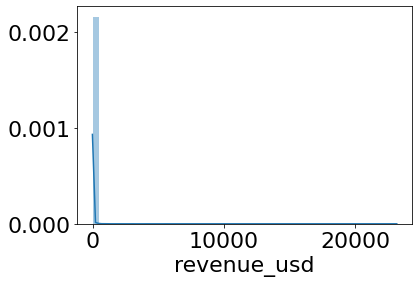

In [32]:
sns.distplot(df['revenue_usd'])

# Purchase vs Non-Purchase

Now we examine how many visits end in a purchase vs no purchase.  The vast majority of site visits end without a purchase of any size being made.

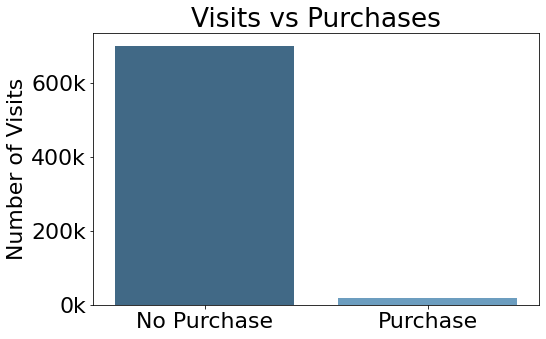

In [33]:
df['purchase'].value_counts()
plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=['No Purchase', 'Purchase'], y=df['purchase'].value_counts(), palette='Blues_d')
plt.ylabel('Number of Visits')
plt.title('Visits vs Purchases')
plt.rcParams.update({'font.size': 22})
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: str(round(y / 1000)) + 'k'))

# EDA for site visits that result in purchases

Only 2.46% of site visits end with a purchase of any amount.  Of the visits that end in a purchase, most are under 100 dollars in total.  The average purchase size is $124.

In [34]:
purchases = df.loc[df['totals_transactionRevenue'] != 0]

2.46% of site visitors made a purchase.
The average purchase value is: $124.47


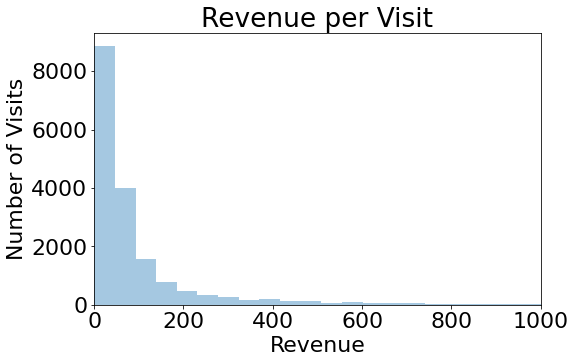

In [35]:
plt.subplots(figsize=(8, 5))
sns.distplot(purchases['revenue_usd'], bins=500, kde=False)
plt.xlim(0, 1000)
plt.xlabel('Revenue')
plt.ylabel('Number of Visits')
plt.title('Revenue per Visit')
plt.rcParams.update({'font.size': 22})


percent_purchase = round(purchases['visitId'].count() / df['visitId'].count() * 100, 2)
print(str(percent_purchase) + "% of site visitors made a purchase.")
print("The average purchase value is: $" + str(round(purchases['revenue_usd'].mean(), 2)))

Of those visitors that make a purchase, the majority of them spend less than 100 dollars.  Average purchase size is $124.47.  Only 2.5% of visits result in a sale of any amount.

# Mobile vs Not

Here we examine spending on mobile devices vs desktop (or similar) devices.  The average purchase size on mobile devices is less than half of the average total from a non-mobile device.  

This could be due to a poor mobile interface or lack of user trust in making large purchases on their phones.

In [37]:
count_mobile = purchases.groupby('device_isMobile').count()
avg_mobile = purchases.groupby('device_isMobile').mean()

Text(0.5, 1.0, 'Average Purchase Amount on Mobile')

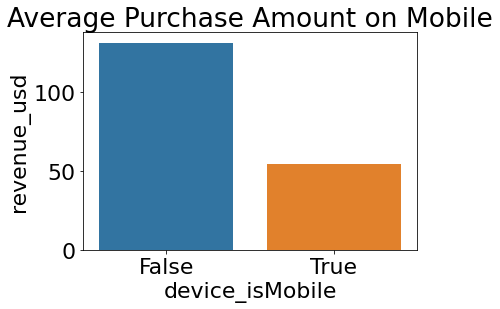

In [38]:
sns.barplot(y=avg_mobile['revenue_usd'], x= avg_mobile.index)
plt.title('Average Purchase Amount on Mobile')

In addition to a smaller average cart size, mobile users also make fewer purchases overall:

Text(0.5, 1.0, 'Number of Purchases on Mobile')

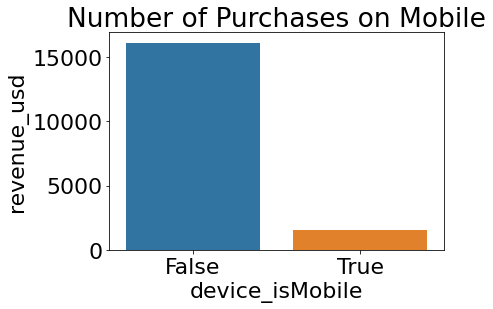

In [39]:
sns.barplot(y=count_mobile['revenue_usd'], x= count_mobile.index)
plt.title('Number of Purchases on Mobile')

# What Percent of Visits End with a Purchase?

Now we examine trends in purchases over time.  In this section we modify our data to time series format and graph trends based on a 4 week rolling average.

In [40]:
def percent_purchase(df, unit_of_time):
    df['date'] = df['date'].astype(str)
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    
    #Get number of purchases per time unit
    df_ts = df[['date', 'purchase']]
    df_ts_gr = df_ts.groupby('date').sum()
    purchases = df_ts_gr.resample(unit_of_time).sum()
    
    #Get number of visits per time unit
    df_ts = df[['date', 'purchase']]
    df_ts_gr = df_ts.groupby('date').count()
    visits = df_ts_gr.resample(unit_of_time).sum()
    visits['visits'] = visits['purchase']
    visits.drop('purchase', axis=1, inplace=True)
    
    #Combine purchases and visits
    df_time = purchases.join(visits, how='inner')
    
    #Calculate percent
    df_time['percent_purchase'] = df_time['purchase'] / df_time['visits'] * 100
    
    return df_time

In [41]:
df_weekly = percent_purchase(df, 'W')
df_monthly = percent_purchase(df, 'M')

### Weekly % Purchases (Rolling 4 Week Avg)

In [43]:
def graph_roll_avg_percent_purchase(df, window):
    rolling_mean = df.rolling(window=window, center=False).mean()
    plt.subplots(figsize=(12, 6))
    ax = sns.lineplot(x=rolling_mean.index, y="percent_purchase", data=rolling_mean)
    plt.ylabel('% Purchase')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.title('Percent Purchase - 4 Week Rolling Average')
    plt.rcParams.update({'font.size': 22})


def graph_roll_avg_visits(df, window):
    rolling_mean = df.rolling(window=window, center=False).mean()
    plt.subplots(figsize=(12, 6))
    ax = sns.lineplot(x=rolling_mean.index, y="visits", data=rolling_mean)
    plt.ylabel('# of Visits')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.title('Weekly Visits- 4 Week Rolling Average')
    plt.rcParams.update({'font.size': 22})


In any week, about 2.5% to 3.5% of visits ended with a purchase.  This changed in October 2017, when the average percent of visits that result in a purchase declined to about 1.5%.

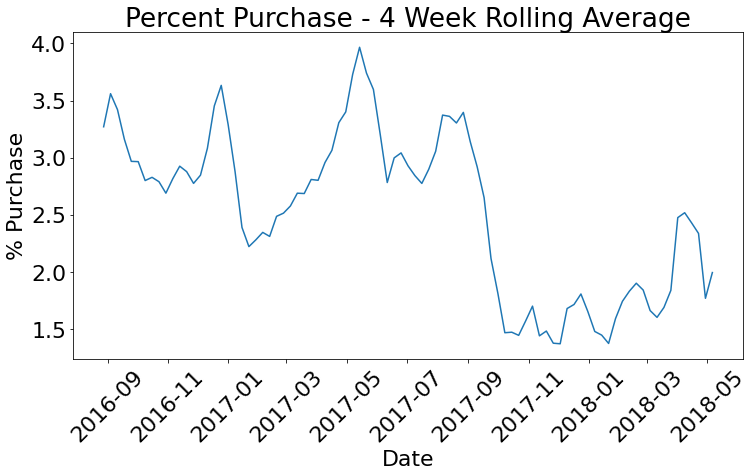

In [44]:
graph_roll_avg_percent_purchase(df_weekly, 4)

One reason for this decrease in the percent of visits that lead to purchases is an increase in overall visits to the site in October 2017.  This corresponds to a large drop of new products from Google.  One possible explanation is that these new products inspired new people to visit the store, but they were not as enthusiastic about buying Google products as previous customers.

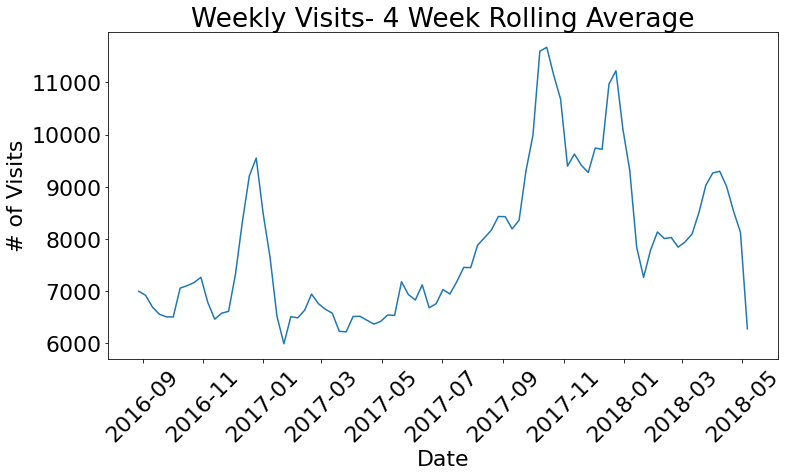

In [45]:
graph_roll_avg_visits(df_weekly, 4)

# What Percent of Visits End with a Purchase?  Mobile vs Not

Now we will repeat the same analysis we did above, while breaking purchases out into those from mobile vs non-mobile devices.

In [46]:
mobile = df.loc[df['device_isMobile'] == True]
non_mobile = df.loc[df['device_isMobile'] == False]

In [47]:
weekly_mobile = percent_purchase(mobile, 'W')
weekly_non_mobile = percent_purchase(non_mobile, 'W')

<ipython-input-40-2431eecb7bad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype(str)
<ipython-input-40-2431eecb7bad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date']).dt.normalize()


### % Purchase - Mobile vs Non-Mobile

The trends are similar to what we saw above, but the swings in purchase percent are less pronounced for mobile visits. 

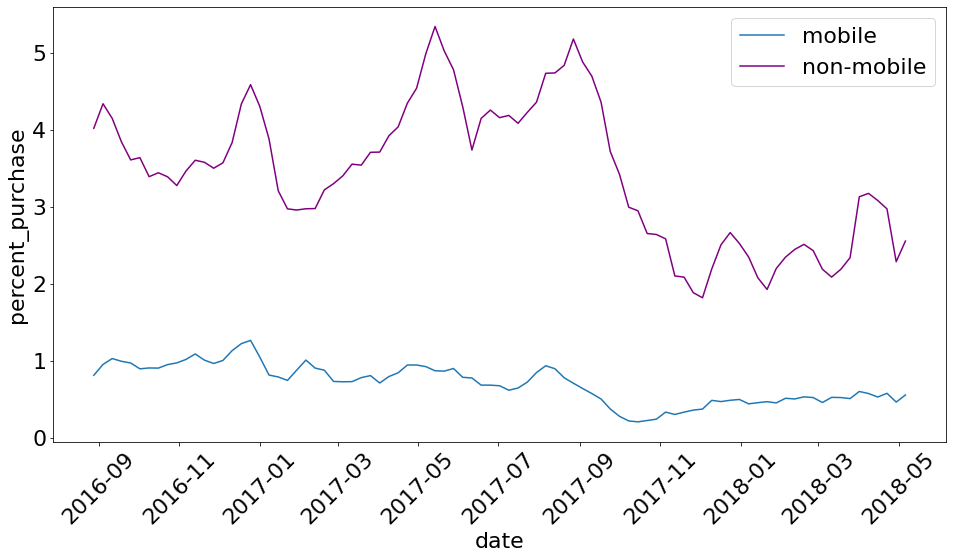

In [58]:
#Graph % for mobile
mobile_rolling_mean = weekly_mobile.rolling(window=4, center=False).mean()
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x=mobile_rolling_mean.index, y="percent_purchase", data=mobile_rolling_mean, label='mobile')
plt.xticks(rotation=45)


#Graph % for non-mobile
non_rolling_mean = weekly_non_mobile.rolling(window=4, center=False).mean()
ax2 = sns.lineplot(x=non_rolling_mean.index, y="percent_purchase", data=non_rolling_mean, color='purple', label='non-mobile')


### Visits per Week - Mobile vs Non-Mobile

Here we can pinpoint the spike in (low purchase rate) mobile visits that lead to the drop in the overall purchase rate.

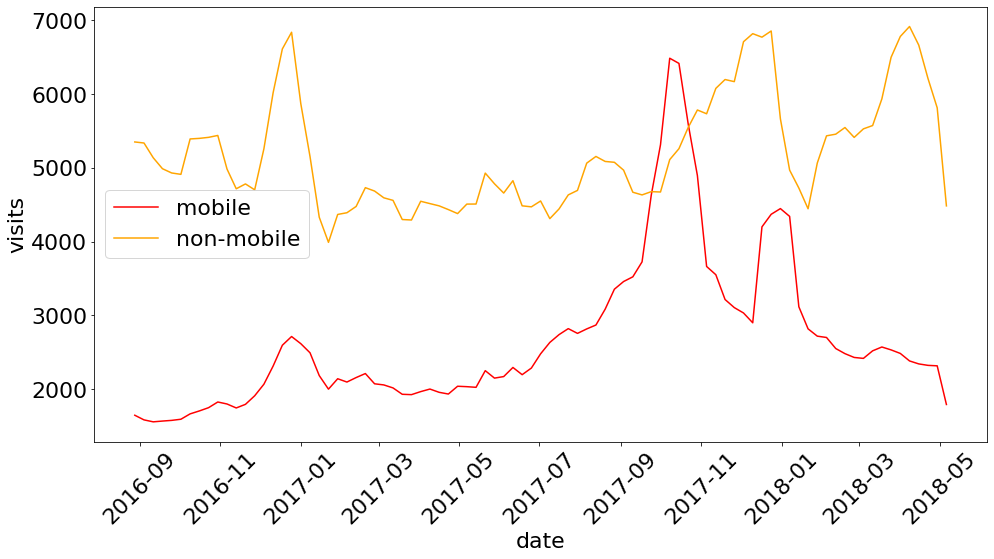

In [59]:
# Mobile visits
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x=mobile_rolling_mean.index, y="visits", data=mobile_rolling_mean, color='red', label = 'mobile')
plt.xticks(rotation=45)


# Non-mobile visits
ax2 = sns.lineplot(x=non_rolling_mean.index, y="visits", data=non_rolling_mean, color='orange', label='non-mobile')
plt.legend()

# Averages by OS

Now we analyze how spending differs based on the operating system of the device that is browsing the store.

In [50]:
df_os = df.loc[df['revenue_usd'] != 0]
df_os_purchase = df_os.groupby('device_operatingSystem').mean().sort_values(by='revenue_usd', ascending=False)

### Avg Spend (of those who made a purchase)

The average purchase size is largest for Windows and Chrome OS machines.  Chrome OS is a Google product, so it makes sense that people who already own Google products would tend to buy more Google products.

Text(0.5, 1.0, 'Average Purchase Amount by Operating System')

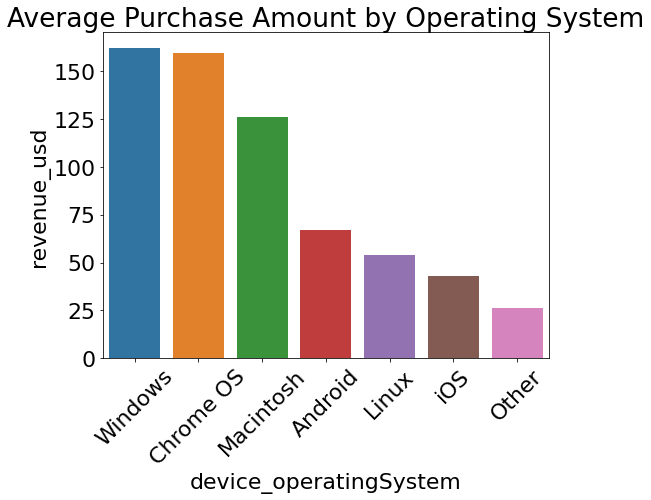

In [61]:
plt.subplots(figsize=(8, 6))
sns.barplot(y=df_os_purchase['revenue_usd'], x= df_os_purchase.index)
plt.xticks(rotation=45)
plt.title('Average Purchase Amount by Operating System')

### Avg % Purchase

Counterintuitively, we see that a large portion of Mac users make a purchase, while a much smaller proportion of Chrome OS users do.

Text(0.5, 1.0, 'Percent of Visits that End in Purchase: by Operating System')

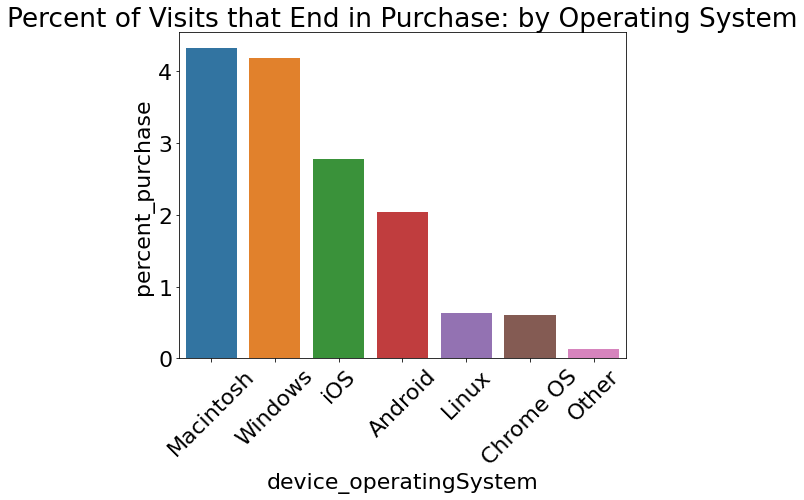

In [62]:
# Groupby OS Count
count = df.groupby('device_operatingSystem').count().sort_values(by='revenue_usd', ascending=False)
count = count[['visitId']]

# Group by OS Sum
total = df.groupby('device_operatingSystem').sum().sort_values(by='revenue_usd', ascending=False)
total = total[['purchase']]

# Calculate Percent
joined = count.join(total, how='inner')
joined['percent_purchase'] = joined['purchase'] / joined['visitId'] * 100

# Graph Percent
plt.subplots(figsize=(8, 6))
sns.barplot(y=joined['percent_purchase'].sort_values(ascending=False), x= joined.index)
plt.xticks(rotation=45)
plt.title('Percent of Visits that End in Purchase: by Operating System')

# Averages by Browser

In [53]:
df_brow = df.loc[df['revenue_usd'] != 0]
df_brow_purchase = df_brow.groupby('device_browser').mean().sort_values(by='revenue_usd', ascending=False)

### Avg Spend (of those who made a purchase)

Firefox users buy far larger amounts than visitors using any other browser.  This could be due to large outlier purchases made by a few Firefox users.  More investigation is warranted.

Text(0.5, 1.0, 'Average Purchase Amount by Browser')

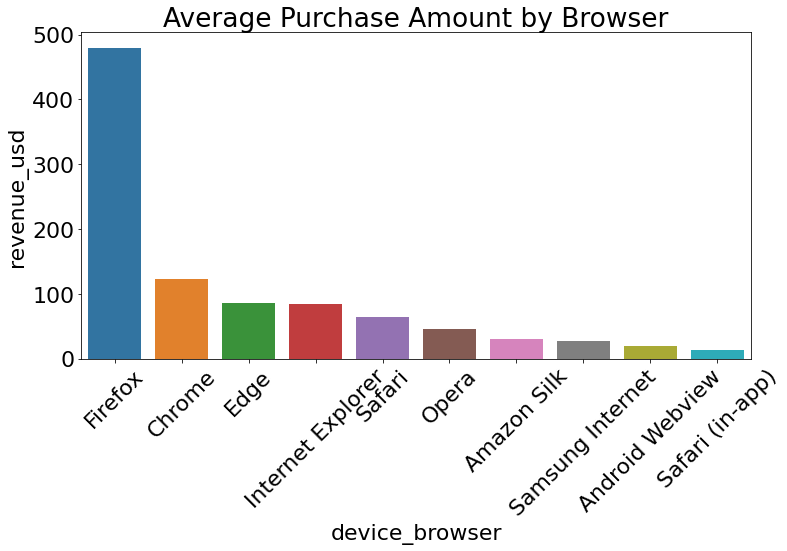

In [63]:
plt.subplots(figsize=(12, 6))
sns.barplot(y=df_brow_purchase['revenue_usd'], x= df_brow_purchase.index)
plt.xticks(rotation=45)
plt.title('Average Purchase Amount by Browser')

### Avg % Purchase

Users that visit the store using Google Chrome make purchases at the highest rate.

Text(0.5, 1.0, 'Percent of Visits that End in Purchase: by Browser')

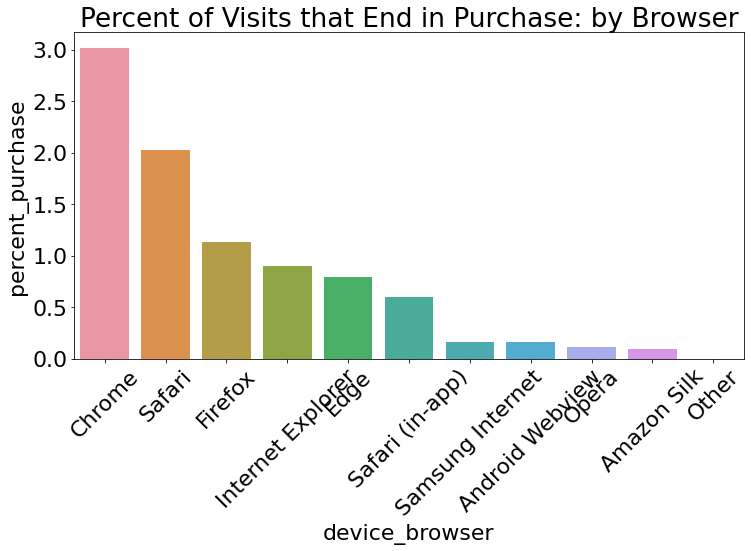

In [64]:
# Groupby OS Count
count = df.groupby('device_browser').count().sort_values(by='revenue_usd', ascending=False)
count = count[['visitId']]

# Group by OS Sum
total = df.groupby('device_browser').sum().sort_values(by='revenue_usd', ascending=False)
total = total[['purchase']]

# Calculate Percent
joined = count.join(total, how='inner')
joined['percent_purchase'] = joined['purchase'] / joined['visitId'] * 100

# Graph Percent
plt.subplots(figsize=(12, 6))
sns.barplot(y=joined['percent_purchase'].sort_values(ascending=False), x= joined.index)
plt.xticks(rotation=45)
plt.title('Percent of Visits that End in Purchase: by Browser')

# **Modeling & Evaluation**

This section of the notebook goes through the stages of modeling before landing on the final Random Forest model used to predict revenue for visits to Google's online store.

**Sections:**
* Importing Data
* Baseline KNN Model
* Tuned KNN Models
* Baseline Decision Tree Model
* Random Forest Models
* Feature Engineering
* Final Model & Evaluation

## Import Data

Import preprocessed data.

In [153]:
df = pd.read_csv('../Data/final_data.csv', dtype={'fullVisitorId': 'str'})
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 30 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   date                                          717217 non-null  object 
 2   device_browser                                717217 non-null  object 
 3   device_deviceCategory                         717217 non-null  object 
 4   device_isMobile                               717217 non-null  bool   
 5   device_operatingSystem                        717217 non-null  object 
 6   fullVisitorId                                 717217 non-null  object 
 7   totals_hits                                   717217 non-null  int64  
 8   totals_pageviews                              717217 non-null  float64
 9   totals_sessionQualityDim                      71

Drop features that do not have predictive capabilities, are duplicates of revenue, or are otherwise unsuitable for regression modeling.

In [2]:
# Filter df for modeling
dfm = df.copy()
dfm.drop(['time', 'totals_totalTransactionRevenue', 'totals_transactionRevenue', 'date', 'fullVisitorId', 'visitId', 'total_revenue_usd', 'totals_transactions', 'purchase'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 21 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   device_browser                                717217 non-null  object 
 2   device_deviceCategory                         717217 non-null  object 
 3   device_isMobile                               717217 non-null  bool   
 4   device_operatingSystem                        717217 non-null  object 
 5   totals_hits                                   717217 non-null  int64  
 6   totals_pageviews                              717217 non-null  float64
 7   totals_sessionQualityDim                      717217 non-null  float64
 8   totals_timeOnSite                             717217 non-null  float64
 9   trafficSource_adContent                       71

# Train Test Split

Split the data into dependent and independent variables for modeling.  Then split into train and test sets.  All model tuning will be done using cross validation on the training data.  The test data will be used only to test the results of the final model.

In [4]:
X = dfm.drop('revenue_usd', axis=1)
Y = dfm['revenue_usd']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=70)

Creating dummy variables with get_dummies.  get_dummies does not drop any categorical columns.  This is not a problem for KNN Regressor, but would need to be updated for models like linear regression.

In [6]:
X_train_ohe = pd.get_dummies(X_train)
X_train_ohe.head()

,device_isMobile,totals_hits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,trafficSource_adwordsClickInfo.page,visitNumber,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,...,trafficSource_source_sites.google.com,trafficSource_source_t.co,trafficSource_source_yahoo,trafficSource_source_youtube.com,time_of_day_Afternoon,time_of_day_Early Morning,time_of_day_Evening,time_of_day_Late Night,time_of_day_Morning,time_of_day_Night
678941,False,9,7.0,2.0,239.509969,0.0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
561021,False,11,7.0,31.0,239.509969,0.0,5,0,0,0,...,0,0,0,0,0,0,1,0,0,0
153899,False,9,7.0,-1.0,239.509969,0.0,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0
54930,False,4,4.0,-1.0,239.509969,0.0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
628845,False,48,28.0,70.0,239.509969,0.0,33,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Now the data is ready for regression modeling.

# Baseline KNN Model

First we run an untuned model to establish a baseline. Normally wouldn't use PCA in the baseline model, but our computational resources are too limited to make predictions without PCA.  All data must be scaled before using any KNN model.

In [73]:
pipe_knn_baseline = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.9)),
            ('knn', KNeighborsRegressor(p=2, n_jobs=-1))])

Here we will implement a GridSearchCV only for its cross validation properties.  All hyperparameters will be the default values in this baseline model.

In [74]:
# Create the grid parameter
grid_knn_baseline = [{'knn__n_neighbors': [5], 
         'knn__weights': ['uniform']}]

# Create the grid, with "pipe" as the estimator
gridsearch_knn_baseline = GridSearchCV(estimator=pipe_knn_baseline, 
                          param_grid=grid_knn_baseline, 
                          scoring=['r2', 'neg_root_mean_squared_error'], 
                          refit='r2',
                          cv=5,
                          n_jobs=-1)

In [75]:
gridsearch_knn_baseline.fit(X_train_ohe, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(n_components=0.9)),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'knn__n_neighbors': [5],
                          'knn__weights': ['uniform']}],
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [77]:
#Save the model
dump(gridsearch_knn_baseline, 'gridsearch_knn_baseline.joblib') 

['gridsearch_knn_baseline.joblib']

In [78]:
gridsearch_knn_baseline_df = pd.DataFrame.from_dict(gridsearch_knn_baseline.cv_results_)
gridsearch_knn_baseline_df['mean_test_r2']

0   -0.046531
Name: mean_test_r2, dtype: float64

In [79]:
gridsearch_knn_baseline.best_score_

-0.046531300371287145

The mean R-Squared value across all folds of cross validation is -0.0465.  This is not high at all (in fact it's negative!), so we will tune our hyperparameters in order to achieve better results.

# Tuned KNN Model

Now we will tune our KNN model's hyperparameters for the number of nearest neighbors and the weight function used in prediction.

In [80]:
#Create pipeline
pipe_knn = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.9)),
            ('knn', KNeighborsRegressor(p=2, n_jobs=-1))])

In [81]:
# Create the grid parameter
grid_knn = [{'knn__n_neighbors': [5, 10, 20, 50, 100], 
         'knn__weights': ['uniform', 'distance']}]

# Create the grid, with "pipe" as the estimator
gridsearch_knn = GridSearchCV(estimator=pipe_knn, 
                          param_grid=grid_knn, 
                          scoring=['r2', 'neg_root_mean_squared_error'], 
                          refit='r2',
                          cv=5,
                          n_jobs=-1)

In [82]:
gridsearch_knn.fit(X_train_ohe, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(n_components=0.9)),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'knn__n_neighbors': [5, 10, 20, 50, 100],
                          'knn__weights': ['uniform', 'distance']}],
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

Throughout the notebook the dump/load functions are used to save and load models so that we do not have to re-fit models each time the notebook/kernel is closed or restarted.

In [83]:
#Save the model
dump(gridsearch_knn, 'gridsearch_knn.joblib') 

['gridsearch_knn.joblib']

In [84]:
gridsearch_knn.best_params_

{'knn__n_neighbors': 50, 'knn__weights': 'distance'}

In [85]:
gridsearch_knn.best_score_

0.12583662687409544

The best model we tested used a distance weight function and 50 nearest neighbors to make its predictions.  The average R-Squared value for this model across all CV folds was 12.6%.  This model also had the 2nd lowest RMSE out of the models we tried.  This is a definite improvement over our baseline model.

Next, we can graph how R-Squared and RMSE change as we modify the number of neighbors.  This will allow us to more accurately target the hyperparameters that will lead to the best result.

In [86]:
#Get results of our modeling.
gridsearch_knn_df = pd.DataFrame.from_dict(gridsearch_knn.cv_results_)
gridsearch_knn_df = gridsearch_knn_df[['param_knn__n_neighbors', 'param_knn__weights', 'mean_test_neg_root_mean_squared_error', 'mean_test_r2']]

#Segment the models into different dataframes depending on the weight function used.
distance_results = gridsearch_knn_df.loc[gridsearch_knn_df['param_knn__weights'] == 'distance'].sort_values(by='param_knn__n_neighbors', ascending=False)
uniform_results = gridsearch_knn_df.loc[gridsearch_knn_df['param_knn__weights'] == 'uniform'].sort_values(by='param_knn__n_neighbors', ascending=False)

### Graph Metrics for Uniform Models

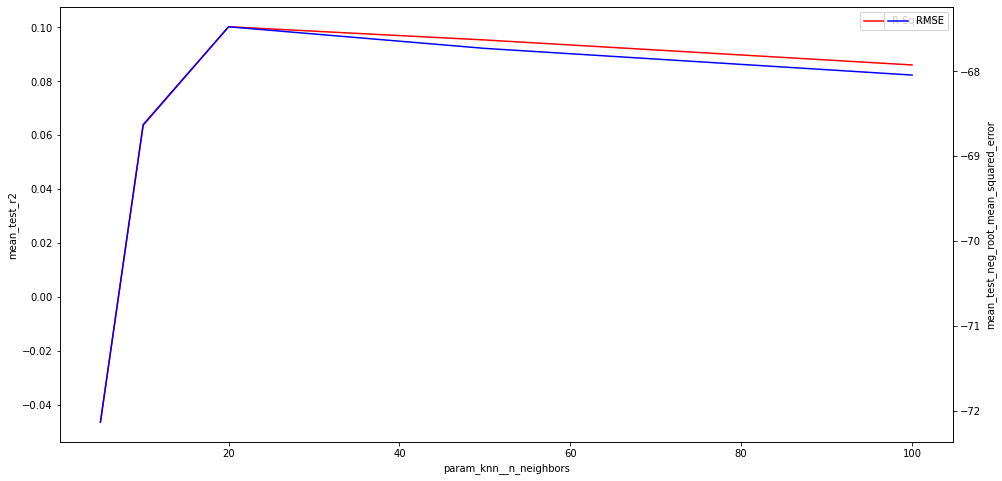

In [87]:
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x='param_knn__n_neighbors', y="mean_test_r2", data=uniform_results, color='red', label = 'R-Squared')
ax2=ax.twinx()
sns.lineplot(x='param_knn__n_neighbors', y="mean_test_neg_root_mean_squared_error", data=uniform_results, color='blue', label = 'RMSE')
plt.legend()

Here we can see that R-Squared increases quickly until about k=20, then the values begin to decrease.  RMSE shows a similar pattern.

### Graph Metrics for Distance Models

<AxesSubplot:label='372b994f-d3ff-4588-a9f1-f33239ed4f27', xlabel='param_knn__n_neighbors', ylabel='mean_test_neg_root_mean_squared_error'>

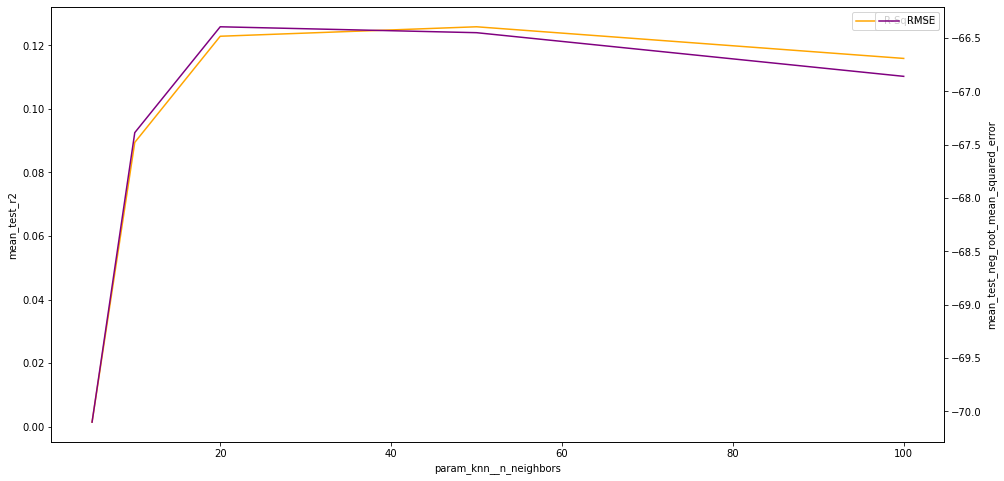

In [88]:
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x='param_knn__n_neighbors', y="mean_test_r2", data=distance_results, color='orange', label = 'R-Squared')
ax2=ax.twinx()
sns.lineplot(x='param_knn__n_neighbors', y="mean_test_neg_root_mean_squared_error", data=distance_results, color='purple', label = 'RMSE')

Here we can see that R-Squared increases quickly until about k=20, then less rapidly through k=50 or so.  Then the values begin to decrease.  RMSE shows a similar pattern.

Now we look at the mean R-Squared values for distance vs uniform weight functions.  Below we can see that for any given number of nearest neighbors k, the distance weight function performs better.  We'll tune our model again using a distance weights and more targeted k values based on the above graphs.

In [89]:
distance_results[['mean_test_r2']]

,mean_test_r2
9,0.115881
7,0.125837
5,0.122857
3,0.089463
1,0.001435


In [90]:
uniform_results[['mean_test_r2']]

,mean_test_r2
8,0.086082
6,0.095358
4,0.100256
2,0.063654
0,-0.046531


# 2nd Tuned KNN Model

In [91]:
# Create the grid parameter using neighbor values based on our previous graphs.
grid_knn_2 = [{'knn__n_neighbors': [30, 40, 50, 60, 70], 
              'knn__weights': ['distance']}]

# Create the grid, with "pipe" as the estimator
gridsearch_knn_2 = GridSearchCV(estimator=pipe_knn, 
                          param_grid=grid_knn_2, 
                          scoring=['r2', 'neg_root_mean_squared_error'], 
                          refit='r2',
                          cv=5,
                          n_jobs=-1)

In [92]:
gridsearch_knn_2.fit(X_train_ohe, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(n_components=0.9)),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'knn__n_neighbors': [30, 40, 50, 60, 70],
                          'knn__weights': ['distance']}],
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [93]:
#Save the model
dump(gridsearch_knn_2, 'gridsearch_knn_2.joblib') 

['gridsearch_knn_2.joblib']

In [94]:
gridsearch_knn_2.best_params_

{'knn__n_neighbors': 30, 'knn__weights': 'distance'}

In [95]:
gridsearch_knn_2.best_score_

0.1307760156344741

In [96]:
gridsearch_knn_df2 = pd.DataFrame.from_dict(gridsearch_knn_2.cv_results_)
gridsearch_knn_df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,params,split0_test_r2,split1_test_r2,split2_test_r2,...,std_test_r2,rank_test_r2,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,88.094349,17.298172,101.715372,18.242396,30,distance,"{'knn__n_neighbors': 30, 'knn__weights': 'dist...",0.162473,0.113972,0.110030,...,0.018636,1,-81.933344,-67.688232,-60.506095,-66.105800,-54.770724,-66.200839,9.086371,1
1,113.544766,10.209081,113.961914,22.678186,40,distance,"{'knn__n_neighbors': 40, 'knn__weights': 'dist...",0.147408,0.115425,0.106944,...,0.015138,2,-82.666978,-67.632711,-60.610897,-66.163183,-54.542355,-66.323225,9.383797,2
2,99.105756,9.053153,145.190903,3.576614,50,distance,"{'knn__n_neighbors': 50, 'knn__weights': 'dist...",0.137240,0.114089,0.107293,...,0.012932,3,-83.158432,-67.683764,-60.599069,-66.265558,-54.538341,-66.449033,9.558754,3
3,128.544312,21.092029,133.932774,27.783990,60,distance,"{'knn__n_neighbors': 60, 'knn__weights': 'dist...",0.133860,0.111045,0.103980,...,0.014561,4,-83.321153,-67.799928,-60.711417,-66.413899,-54.423360,-66.533952,9.633230,4
4,125.881806,21.276147,137.298022,56.974928,70,distance,"{'knn__n_neighbors': 70, 'knn__weights': 'dist...",0.126118,0.109275,0.098608,...,0.014753,5,-83.692720,-67.867407,-60.893141,-66.565431,-54.485830,-66.700906,9.726655,5


Our 2nd iteration of tuning the KNN model results in our best model using 30 nearest neighbors with a distance weighting function.  This model is better than our previous best with R-Squared of 13.1% and RMSE of 66.2 vs previous R-Squared of 12.6% and RMSE of 66.4.

In [97]:
gridsearch_knn_df2['mean_test_r2'][0]

0.1307760156344741

In [98]:
gridsearch_knn_df2['mean_test_neg_root_mean_squared_error'][0]

-66.2008390626158

In [99]:
gridsearch_knn_df[['mean_test_r2', 'mean_test_neg_root_mean_squared_error']]

,mean_test_r2,mean_test_neg_root_mean_squared_error
0,-0.046531,-72.130892
1,0.001435,-70.100076
2,0.063654,-68.627431
3,0.089463,-67.385914
4,0.100256,-67.475206
5,0.122857,-66.393671
6,0.095358,-67.729646
7,0.125837,-66.449033
8,0.086082,-68.043727
9,0.115881,-66.858341


We have tuned our KNN model, but the R-Squared metric still is not as high as we might like.  About 13% of the variation in revenue can be explained by our tuned model.  The KNN model is limited both by our computational resources and by how KNN performs when there are many dimensions and many rows.

Additionally, we want to analyze which features are most important in predicting how much a customer spends.  This is not possible with a KNN model.  

Tree-based models do have this functionality.  Our next step is to implement a decision tree regressor.  Once we have a sufficient tree-based model, we will examine the Gini Importance of different features to make conclusions about online shopping at Google's store.

# Decision Tree Model

In tuning this model we need to use a RandomizedSearchCV because our computational resources are limited.  We will tune based on a random selection from the starting hyperparameters, then look for patterns and tune again from there.

In [16]:
#Create pipeline
pipe_tree = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.9)),
            ('tree', DecisionTreeRegressor(random_state=70))])

In [17]:
# Create the grid parameter
grid_tree = [{'tree__max_depth': [10, 20, 35, 50], 
             'tree__min_samples_split': [5, 10, 30, 40, 50],
             'tree__min_samples_leaf': [10, 30, 100, 300],
             'tree__criterion': ['mse'],
             'tree__max_features': [None, 'sqrt', 'log2']
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_tree = RandomizedSearchCV(estimator=pipe_tree, 
                          param_distributions=grid_tree, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          cv=5,
                          n_iter=15,
                          n_jobs=-1,
                          verbose=8)

In [18]:
gridsearch_tree.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed: 17.7min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 19.1min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scl', StandardScaler()),
                                             ('pca', PCA(n_components=0.9)),
                                             ('tree',
                                              DecisionTreeRegressor(random_state=70))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'tree__criterion': ['mse'],
                                         'tree__max_depth': [10, 20, 35, 50],
                                         'tree__max_features': [None, 'sqrt',
                                                                'log2'],
                                         'tree__min_samples_leaf': [10, 30, 100,
                                                                    300],
                                         'tree__min_samples_split': [5, 10, 30,
                                                                     40, 50]}],
                   refit='r2'

In [60]:
#Save the model
dump(gridsearch_tree, 'gridsearch_tree.joblib') 

['gridsearch_tree.joblib']

In [21]:
gridsearch_tree.best_params_

{'tree__min_samples_split': 50,
 'tree__min_samples_leaf': 30,
 'tree__max_features': None,
 'tree__max_depth': 10,
 'tree__criterion': 'mse'}

The best R-Squared score from this model is 8.6%.  This is lower than our tuned KNN model, but high enough to continue iterating with tree-based models.  A random forest model may be more effective than a single decision tree.

In [22]:
gridsearch_tree.best_score_

0.08593649123624995

In [24]:
gridsearch_tree_df = pd.DataFrame.from_dict(gridsearch_tree.cv_results_)
gridsearch_tree_df.loc[gridsearch_tree_df['rank_test_r2'] < 6]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__min_samples_split,param_tree__min_samples_leaf,param_tree__max_features,param_tree__max_depth,param_tree__criterion,params,...,std_test_r2,rank_test_r2,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
6,84.608612,9.707482,6.210377,1.502562,50,100,log2,10,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.015772,5,-86.582035,-69.502612,-61.726951,-67.327202,-55.903973,-68.208555,10.329086,6
7,178.413115,9.101852,4.666100,0.209530,50,30,None,10,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.017522,1,-84.386796,-68.337727,-61.919314,-67.862211,-56.863729,-67.873955,9.269002,1
8,217.496099,11.545997,4.767680,0.528180,5,100,None,20,mse,"{'tree__min_samples_split': 5, 'tree__min_samp...",...,0.007800,3,-85.796761,-68.706170,-61.507549,-67.440552,-56.494466,-67.989100,9.920332,3
13,212.562081,16.824093,4.036405,0.447493,40,100,None,50,mse,"{'tree__min_samples_split': 40, 'tree__min_sam...",...,0.007800,2,-85.796720,-68.706170,-61.507571,-67.440555,-56.494466,-67.989096,9.920315,2
14,165.105033,42.882446,2.617595,0.725113,50,30,None,20,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.017682,4,-84.619476,-68.493799,-62.154031,-68.082234,-56.960312,-68.061970,9.300413,4


Here we can see that our 'best' parameters in terms of R-Squared also achieve the lowest RMSE.

Other trends to note:
* min_samples_split is generally at the higher end of the possible range for the highest ranked hyperparameters.
* max_features is None for most of the highest ranked hyperparameters
* max_depth is mostly in the 10-20 range.
* min_samples_leaf is 30 or 100 for each of the top 5 ranked models.

Next we will use this information to tailor our list of possible hyperparameters and tune again.

# 2nd Iteration - Tuned Decision Tree Model

Here we adjust the grid parameters based on the results of the first model.

In [25]:
# Create the grid parameter
grid_tree2 = [{'tree__max_depth': [10, 15, 20, 25, 30], 
             'tree__min_samples_split': [40, 50, 60, 70, 100],
             'tree__min_samples_leaf': [25, 40, 50, 50, 75, 100],
             'tree__criterion': ['mse'],
             'tree__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_tree2 = RandomizedSearchCV(estimator=pipe_tree, 
                          param_distributions=grid_tree2, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          cv=5,
                          n_iter=15,
                          n_jobs=-1,
                          verbose=8)

In [26]:
gridsearch_tree2.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed: 18.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 19.5min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scl', StandardScaler()),
                                             ('pca', PCA(n_components=0.9)),
                                             ('tree',
                                              DecisionTreeRegressor(random_state=70))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'tree__criterion': ['mse'],
                                         'tree__max_depth': [10, 15, 20, 25,
                                                             30],
                                         'tree__max_features': [None],
                                         'tree__min_samples_leaf': [25, 40, 50,
                                                                    50, 75,
                                                                    100],
                                         'tree__min_samples_split': [40, 50, 60,
                                                

In [59]:
#Save the model
dump(gridsearch_tree2, 'gridsearch_tree2.joblib') 

['gridsearch_tree2.joblib']

In [27]:
gridsearch_tree2.best_params_

{'tree__min_samples_split': 50,
 'tree__min_samples_leaf': 25,
 'tree__max_features': None,
 'tree__max_depth': 10,
 'tree__criterion': 'mse'}

The score has improved, but is still not at the same level as the KNN model.

In [28]:
gridsearch_tree2.best_score_

0.10214052833658269

In [29]:
gridsearch_tree_df2 = pd.DataFrame.from_dict(gridsearch_tree2.cv_results_)
gridsearch_tree_df2.loc[gridsearch_tree_df2['rank_test_r2'] < 6]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__min_samples_split,param_tree__min_samples_leaf,param_tree__max_features,param_tree__max_depth,param_tree__criterion,params,...,std_test_r2,rank_test_r2,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,160.721360,0.866581,2.789838,0.067428,100,25,None,15,mse,"{'tree__min_samples_split': 100, 'tree__min_sa...",...,0.025763,5,-84.423167,-68.323677,-60.949473,-67.625181,-57.712221,-67.806744,9.223093,5
1,150.488482,16.630706,2.791974,0.149412,50,75,None,25,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.013869,2,-85.203881,-68.827723,-61.501614,-66.864987,-56.544852,-67.788611,9.707450,2
7,116.154980,14.068190,2.832764,0.216005,100,75,None,30,mse,"{'tree__min_samples_split': 100, 'tree__min_sa...",...,0.013869,2,-85.203881,-68.827723,-61.501614,-66.864987,-56.544852,-67.788611,9.707450,2
8,81.416739,1.667214,2.990481,0.345178,50,25,None,10,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.047372,1,-80.948403,-68.371313,-60.770486,-67.554064,-57.815141,-67.091881,7.998396,1
13,100.158337,3.901560,2.630342,0.475071,40,75,None,15,mse,"{'tree__min_samples_split': 40, 'tree__min_sam...",...,0.013892,4,-85.194629,-68.840183,-61.501646,-66.864986,-56.541874,-67.788663,9.705085,4


The best decision tree model has an R-Squared of 10.2%.  It also has the best RMSE (67.1) of the models we tested.  This is not as accurate as the tuned KNN model, but it gives us the insight that tree-based models could be useful in modeling our data.  

Based on this insight we can move on to use a Random Forest Regressor.  This model will aggregate many different Decision Trees, thus creating a more robust model that is less prone to overfitting.

# Random Forest Model

We start with a wide range of parameters.  This will give us a good starting point, and we can further tune the model in the next iteration.

In [46]:
#Create pipeline
pipe_forest = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.85)),
            ('forest', RandomForestRegressor(random_state=70, n_jobs=-1, warm_start=True))])

In [48]:
# Create the grid parameter

#fewer values in larger range

grid_forest = [{'forest__n_estimators': [50, 100, 150], #~100
             'forest__max_depth': [1, 15, 50], 
             'forest__min_samples_split': [5, 25, 50], #try lowering
             'forest__min_samples_leaf': [5, 25, 50], #try lowering
             'forest__criterion': ['mse'],
             'forest__max_features': [None],
#              'forest__min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4], #more subtle
#              'forest__oob_score': [False, True]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_forest = RandomizedSearchCV(estimator=pipe_forest, 
                          param_distributions=grid_forest, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          return_train_score=True, #Include training results in cv_results
                          cv=5, #Use 5 folds in CV process
                          n_iter=5, #Try 15 hyperparameter combinations
                          n_jobs=-1, #Use paralell computing
                          verbose=8) #Give updates on progress during fitting

In [49]:
gridsearch_forest.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed: 64.6min remaining: 50.7min
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed: 143.7min remaining: 55.9min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed: 173.7min remaining: 23.7min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 176.0min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scl', StandardScaler()),
                                             ('pca', PCA(n_components=0.85)),
                                             ('forest',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=70,
                                                                    warm_start=True))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'forest__criterion': ['mse'],
                                         'forest__max_depth': [1, 15, 50],
                                         'forest__max_features': [None],
                                         'forest__min_samples_leaf': [5, 25,
                                                                      50],
                                         'forest__min_samples_split': [5, 25,
                           

In [50]:
gridsearch_forest.best_params_

{'forest__n_estimators': 100,
 'forest__min_samples_split': 25,
 'forest__min_samples_leaf': 50,
 'forest__max_features': None,
 'forest__max_depth': 15,
 'forest__criterion': 'mse'}

In [51]:
gridsearch_forest.best_score_

0.11946150306035266

Our best model had hyperparameters that were in the middle ranges of our gridsearch.  Additionally, our result improved on the R-Squared score from our Decision Tree.  Now we will take a look at our best RF models so that we can decide how to proceed.

In [58]:
#Save the model
dump(gridsearch_forest, 'gridsearch_forest.joblib') 

['gridsearch_forest.joblib']

Now take a look at our top performing models.

In [54]:
gridsearch_forest_df = pd.DataFrame.from_dict(gridsearch_forest.cv_results_)
best_models = gridsearch_forest_df.loc[gridsearch_forest_df['rank_test_r2'] < 6]

In [57]:
best_models[['params', 'rank_test_r2','mean_test_r2', 'mean_train_r2', 'rank_test_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error']]

,params,rank_test_r2,mean_test_r2,mean_train_r2,rank_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
0,"{'forest__n_estimators': 50, 'forest__min_samp...",5,0.044957,0.044415,5,-69.520763,-70.181720
1,"{'forest__n_estimators': 50, 'forest__min_samp...",2,0.118616,0.162620,2,-66.787437,-65.700502
2,"{'forest__n_estimators': 150, 'forest__min_sam...",3,0.088677,0.328945,3,-67.685725,-58.832197
3,"{'forest__n_estimators': 100, 'forest__min_sam...",4,0.046769,0.046580,4,-69.461542,-70.100726
4,"{'forest__n_estimators': 100, 'forest__min_sam...",1,0.119462,0.163623,1,-66.762830,-65.659199


Comparison between the mean train and mean test scores in the table above shows us that our model is overfitting to the training data a bit.  We'll keep this in mind when coming up with the parameters for our next iteration of tuning the model.

In [62]:
best_models['params'][4]

{'forest__n_estimators': 100,
 'forest__min_samples_split': 25,
 'forest__min_samples_leaf': 50,
 'forest__max_features': None,
 'forest__max_depth': 15,
 'forest__criterion': 'mse'}

In [63]:
best_models['params'][1]

{'forest__n_estimators': 50,
 'forest__min_samples_split': 25,
 'forest__min_samples_leaf': 50,
 'forest__max_features': None,
 'forest__max_depth': 50,
 'forest__criterion': 'mse'}

Our 2 best models had scores far above our other models.  We'll use the parameters for these models to narrow in on our choices for our next iteration.
*  'min_samples_split': 25
*  'min_samples_leaf': 50
*  'n_estimators' between 50-100
*  'max_depth between 15 and 50

# 2nd Random Forest Model

Here we tune another iteration of a Random Forest model.  We use values in a closer range around the successful values from the previous top-ranked models.  Additionally we consider using higher min_samples parameters to prune the tree and prevent overfitting to the training data.

In [65]:
# Create the grid parameter
grid_forest2 = [{'forest__n_estimators': [60, 80, 100], 
             'forest__max_depth': [15, 25, 40, 50], 
             'forest__min_samples_split': [20, 25, 30], 
             'forest__min_samples_leaf': [40, 50, 60],
             'forest__criterion': ['mse'],
             'forest__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_forest2 = RandomizedSearchCV(estimator=pipe_forest, 
                          param_distributions=grid_forest2, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          return_train_score=True, #Include training results in cv_results
                          cv=5, #Use 5 folds in CV process
                          n_iter=5, #Try 5 hyperparameter combinations
                          n_jobs=-1, #Use paralell computing
                          verbose=8) #Give updates on progress during fitting

In [66]:
gridsearch_forest2.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed: 135.0min remaining: 106.1min
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed: 175.1min remaining: 68.1min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed: 183.9min remaining: 25.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 188.0min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scl', StandardScaler()),
                                             ('pca', PCA(n_components=0.85)),
                                             ('forest',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=70,
                                                                    warm_start=True))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'forest__criterion': ['mse'],
                                         'forest__max_depth': [15, 25, 40, 50],
                                         'forest__max_features': [None],
                                         'forest__min_samples_leaf': [40, 50,
                                                                      60],
                                         'forest__min_samples_split': [20, 25,
                    

In [67]:
gridsearch_forest2.best_params_

{'forest__n_estimators': 60,
 'forest__min_samples_split': 30,
 'forest__min_samples_leaf': 40,
 'forest__max_features': None,
 'forest__max_depth': 40,
 'forest__criterion': 'mse'}

In [68]:
gridsearch_forest2.best_score_

0.12322398250039837

We've further tuned our model, however the gain to R-Squared is fairly minimal (from 11.9% to 12.3%).  

In [69]:
#Save the model
dump(gridsearch_forest2, 'gridsearch_forest2.joblib') 

['gridsearch_forest2.joblib']

Our top model in terms of R-Squared also has the best RMSE (66.6).  The gains in performance using tree-based models are slowing, so it may be time to try a different flavor of model.

In [72]:
gridsearch_forest_df2 = pd.DataFrame.from_dict(gridsearch_forest2.cv_results_)
best_models2 = gridsearch_forest_df2.loc[gridsearch_forest_df2['rank_test_r2'] < 6]
best_models2[['params', 'rank_test_r2','mean_test_r2', 'mean_train_r2', 'rank_test_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error']]

,params,rank_test_r2,mean_test_r2,mean_train_r2,rank_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
0,"{'forest__n_estimators': 60, 'forest__min_samp...",5,0.117283,0.153755,5,-66.858877,-66.047053
1,"{'forest__n_estimators': 80, 'forest__min_samp...",2,0.122513,0.176656,2,-66.625240,-65.144953
2,"{'forest__n_estimators': 60, 'forest__min_samp...",3,0.119174,0.162719,3,-66.769854,-65.695607
3,"{'forest__n_estimators': 60, 'forest__min_samp...",1,0.123224,0.175657,1,-66.596075,-65.185283
4,"{'forest__n_estimators': 60, 'forest__min_samp...",4,0.117283,0.153755,4,-66.858877,-66.047053


# Feature Engineering - From Original Data

More explanatory variables are needed in order to improve our models.  First we'll pull in additional data relating to page hits and the customer's location from our data source.  This new data is saved in data3.csv.  Preprocessing on this data is shown in the Preprocessing_additional_data.ipynb notebook.

### Pull in Additional Data

In [2]:
df2 = pd.read_csv('../Data/data3.csv', dtype={'fullVisitorId': 'str'})
df2.drop('Unnamed: 0', axis=1, inplace=True)
df2.info()

/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (66,76,84,85,93) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Columns: 123 entries, Unnamed: 0.1 to visitNumber
dtypes: bool(2), float64(3), int64(10), object(108)
memory usage: 663.5+ MB


Since we are only using data from the USA in this analysis, most of the geoNetwork data is not useful.  We'll drop it here but keep the networkDomain column.  Then group together the most unique values so that the column will be usable in the modeling.

In [3]:
df2.drop(['geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country'], axis=1, inplace=True)

In [4]:
top_net_domain = list(df2['geoNetwork.networkDomain'].value_counts().head(31).index)
df2['geoNetwork.networkDomain'] = df2['geoNetwork.networkDomain'].apply(lambda x: x if x in top_net_domain else 'Other')
df2['geoNetwork.networkDomain'].replace('(not set)', 'None', inplace=True)
df2['geoNetwork.networkDomain'].value_counts()

None                   360315
Other                   92205
comcast.net             55484
unknown.unknown         36636
rr.com                  28708
verizon.net             26545
comcastbusiness.net     16826
cox.net                 10721
sbcglobal.net           10596
optonline.net            9734
google.com               9621
att.net                  9255
qwest.net                6940
bhn.net                  5361
spcsdns.net              4684
amazonaws.com            3566
myvzw.com                2827
com                      2486
mycingular.net           2441
suddenlink.net           2421
windstream.net           2399
cogentco.com             2381
rcn.com                  1990
ztomy.com                1936
frontiernet.net          1867
embarqhsd.net            1568
telepacific.net          1568
mchsi.com                1420
wideopenwest.com         1414
twtelecom.net            1130
telia.net                1093
wayport.net              1079
Name: geoNetwork.networkDomain, dtype: i

In [5]:
# Filter df for modeling
dfm2 = df2.copy()
dfm2.drop(['time', 'totals.totalTransactionRevenue', 'totals.transactionRevenue', 'date', 'fullVisitorId', 'visitId', 'total_revenue_usd', 'totals.transactions', 'purchase'], axis=1, inplace=True)
dfm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Columns: 111 entries, Unnamed: 0.1 to visitNumber
dtypes: bool(1), float64(2), int64(6), object(102)
memory usage: 602.6+ MB


In [6]:
dfm2.head()

,Unnamed: 0.1,channelGrouping,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.networkDomain,hits_action_type,hits_affiliation,hits_contentGroup1,...,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitNumber
0,0,Referral,Chrome,desktop,False,Chrome OS,None,"['0', '0']",NaN,"['(not set)', '(not set)']",...,Other,None,0.0,None,None,Other,referral,Other,sites.google.com,6
1,1,Direct,Chrome,mobile,True,Android,Other,"['0', '0']",NaN,"['(not set)', '(not set)']",...,Other,None,0.0,None,None,Other,None,Other,(direct),1
2,2,Referral,Chrome,desktop,False,Macintosh,unknown.unknown,"['0', '0']",NaN,"['(not set)', '(not set)']",...,Other,None,0.0,None,None,Other,None,/offer/2145,(direct),1
3,3,Organic Search,Safari,mobile,True,iOS,bhn.net,"['0', '0']",NaN,"['(not set)', '(not set)']",...,Other,None,0.0,None,None,None,organic,Other,google,1
4,4,Paid Search,Safari,mobile,True,iOS,att.net,"['0', '0']",NaN,"['(not set)', '(not set)']",...,Other,None,0.0,None,Other,(Remarketing/Content targeting),cpc,Other,google,10


### Extract Features from 'Hits' Columns

The hits column contains a large number of features, many of which are not in a format suitable for modeling.  Extract useful features relating to the most recent page visits:

#### Get Product Subcategory of Last Viewed Item

In [7]:
dfm2['hits_v2ProductCategory'].fillna("'None'", inplace=True)

In [8]:
dfm2['product_category'] = dfm2['hits_v2ProductCategory'].apply(lambda x: str(x).split("'")[1])

In [9]:
dfm2['product_category'].replace("(not set)", "None", inplace=True)

In [10]:
dfm2['product_category'] = dfm2['product_category'].apply(lambda x: str(x).split("/")[1] if "/" in str(x) else str(x))

In [11]:
top_prod_cats = list(dfm2['product_category'].value_counts().head(14).index)
dfm2['product_category'] = dfm2['product_category'].apply(lambda x: x if x in top_prod_cats else 'Other')
dfm2['product_category'].value_counts()

None              336406
Apparel           149446
Shop by Brand      89570
Bags               31818
Accessories        27640
Electronics        27332
Drinkware          25017
Office             18625
TYCTWD 2018         3133
Other               2203
${escCatTitle}      1302
Limited Supply      1296
Lifestyle           1274
Gift Cards          1173
Clearance Sale       982
Name: product_category, dtype: int64

#### Get Price of Last Viewed Item

In [12]:
dfm2['hits_productPrice'].fillna("'0'", inplace=True)

In [13]:
dfm2['product_price'] = dfm2['hits_productPrice'].apply(lambda x: str(x).split("'")[1])

In [14]:
dfm2['product_price'] = dfm2['product_price'].astype(int)
dfm2['product_price'] = dfm2['product_price'] / (10**6)

## Drop Unneeded 'Hits' Columns

In [15]:
unused_hits = []
for col in dfm2.columns:
    if 'hits_' in col:
        unused_hits.append(col)
dfm2.drop(unused_hits, axis=1, inplace=True)

In [16]:
dfm2.drop('Unnamed: 0.1', axis=1, inplace=True)
dfm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 24 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   device.browser                                717217 non-null  object 
 2   device.deviceCategory                         717217 non-null  object 
 3   device.isMobile                               717217 non-null  bool   
 4   device.operatingSystem                        717217 non-null  object 
 5   geoNetwork.networkDomain                      717217 non-null  object 
 6   revenue_usd                                   717217 non-null  float64
 7   time_of_day                                   717217 non-null  object 
 8   totals.hits                                   717217 non-null  int64  
 9   totals.pageviews                              71

Save the updated data for easier access when re-running the notebook.

In [17]:
dfm2.to_csv('../Data/data4.csv')

# Feature Engineering - K Means Clustering

Clustering is another method we can use to add explanatory variables to our model.  Here we use K Means clustering to group our data into clusters.  Once finished, we will add the cluster labels and silhouette scores to our data as additional columns.  Then we will re-run the tuned Random Forest model.

## Train Test Split

To prevent leakage from test data, we will split into train and test sets before clustering.  When we test our final model we will add a separate clustering column to the test data.

In [4]:
dfm2 = pd.read_csv('../Data/data4.csv')
dfm2.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
X = dfm2.drop('revenue_usd', axis=1)
Y = dfm2['revenue_usd']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=70)

Creating dummy variables with get_dummies.  get_dummies does not drop any categorical columns.  This is not a problem for the models we have used so far, but would need to be updated for models like linear regression.

In [7]:
X_train_ohe = pd.get_dummies(X_train)
X_train_ohe.head()

,device.isMobile,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,trafficSource.adwordsClickInfo.page,visitNumber,product_price,channelGrouping_(Other),channelGrouping_Affiliates,...,product_category_Drinkware,product_category_Electronics,product_category_Gift Cards,product_category_Lifestyle,product_category_Limited Supply,product_category_None,product_category_Office,product_category_Other,product_category_Shop by Brand,product_category_TYCTWD 2018
678941,False,9,7,2,101,0.0,1,1.99,0,0,...,0,0,0,0,0,0,1,0,0,0
561021,False,11,7,31,111,0.0,5,74.99,0,0,...,0,0,0,0,0,0,0,0,0,0
153899,False,9,7,-1,115,0.0,2,34.99,0,0,...,0,1,0,0,0,0,0,0,0,0
54930,False,4,4,-1,64,0.0,1,16.99,0,0,...,0,0,0,0,0,0,0,0,1,0
628845,False,48,28,70,228,0.0,33,18.99,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clustering

Because of limits on computational resources, we scale and do PCA before clustering.  This will decrease multidimensionality and reduce the computer power needed to cluster.

In [53]:
#Create pipeline to reduce data dimensionality
pipe_reduce = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.75, random_state=70))])

In [ ]:
X_train_reduced = pipe_reduce.fit_transform(X_train_ohe)

Check that dimensionality was reduced & number of samples remained the same.

In [55]:
X_train_ohe.shape

(573773, 181)

In [56]:
X_train_reduced.shape

(573773, 78)

Search through a list of values to find the best k value for the KMeans algorithm.  We use the inertia-based elbow method and silhouette scores to decide which k value is 'best'.

In [58]:
distortions = []
silhouette_plot = []
ch_score = []
k_values = [3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50,55, 60, 65,70, 75,80, 90, 100, 150, 200, 250, 300, 500]
for k in tqdm(k_values):
    #Create KMeans model object
    clusters = KMeans(n_clusters=k, random_state=70, n_jobs=-1, algorithm='full')
    print("Model Created with k=" + str(k))
    
    #Fit model.
    cluster_fit = clusters.fit(X_train_reduced)
    print("Model Fit Complete")
    
    #Get predictions for use in silhouette score calculations
    cluster_labels = cluster_fit.predict(X_train_reduced)
    print("Predictions from Model Complete")
    silhouette_avg = silhouette_score(X_train_ohe, cluster_labels, sample_size=2500, random_state=70)
    silhouette_plot.append(silhouette_avg)
    ch_score.append(calinski_harabasz_score(X_train_reduced, cluster_fit.labels_))
    
    #Get inertia value for use in elbow plot
    distortions.append(cluster_fit.inertia_)
    print("Loop Complete for k=" + str(k) + " Model")

  0%|          | 0/24 [00:00<?, ?it/s]

Model Created with k=3


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


  4%|▍         | 1/24 [00:14<05:36, 14.62s/it]

Loop Complete for k=3 Model
Model Created with k=5


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


  8%|▊         | 2/24 [00:30<05:30, 15.03s/it]

Loop Complete for k=5 Model
Model Created with k=10


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 12%|█▎        | 3/24 [00:51<05:50, 16.70s/it]

Loop Complete for k=10 Model
Model Created with k=15


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 17%|█▋        | 4/24 [01:16<06:23, 19.16s/it]

Loop Complete for k=15 Model
Model Created with k=20


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 21%|██        | 5/24 [01:45<07:02, 22.24s/it]

Loop Complete for k=20 Model
Model Created with k=25


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 25%|██▌       | 6/24 [02:20<07:50, 26.14s/it]

Loop Complete for k=25 Model
Model Created with k=30


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 29%|██▉       | 7/24 [03:02<08:43, 30.78s/it]

Loop Complete for k=30 Model
Model Created with k=35


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 33%|███▎      | 8/24 [03:48<09:28, 35.53s/it]

Loop Complete for k=35 Model
Model Created with k=40


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 38%|███▊      | 9/24 [04:40<10:06, 40.41s/it]

Loop Complete for k=40 Model
Model Created with k=45


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 42%|████▏     | 10/24 [05:38<10:39, 45.65s/it]

Loop Complete for k=45 Model
Model Created with k=50


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 46%|████▌     | 11/24 [06:44<11:11, 51.65s/it]

Loop Complete for k=50 Model
Model Created with k=55


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 50%|█████     | 12/24 [07:57<11:38, 58.17s/it]

Loop Complete for k=55 Model
Model Created with k=60


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 54%|█████▍    | 13/24 [09:16<11:47, 64.35s/it]

Loop Complete for k=60 Model
Model Created with k=65


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 58%|█████▊    | 14/24 [10:43<11:50, 71.03s/it]

Loop Complete for k=65 Model
Model Created with k=70


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 62%|██████▎   | 15/24 [12:23<11:57, 79.73s/it]

Loop Complete for k=70 Model
Model Created with k=75


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 67%|██████▋   | 16/24 [14:12<11:48, 88.52s/it]

Loop Complete for k=75 Model
Model Created with k=80


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 71%|███████   | 17/24 [16:00<11:00, 94.36s/it]

Loop Complete for k=80 Model
Model Created with k=90


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 75%|███████▌  | 18/24 [18:00<10:12, 102.06s/it]

Loop Complete for k=90 Model
Model Created with k=100


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 79%|███████▉  | 19/24 [20:14<09:19, 111.81s/it]

Loop Complete for k=100 Model
Model Created with k=150


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 83%|████████▎ | 20/24 [23:39<09:19, 139.76s/it]

Loop Complete for k=150 Model
Model Created with k=200


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 88%|████████▊ | 21/24 [28:07<08:54, 178.21s/it]

Loop Complete for k=200 Model
Model Created with k=250


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 92%|█████████▏| 22/24 [33:59<07:40, 230.17s/it]

Loop Complete for k=250 Model
Model Created with k=300


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 96%|█████████▌| 23/24 [40:38<04:41, 281.06s/it]

Loop Complete for k=300 Model
Model Created with k=500


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


100%|██████████| 24/24 [53:37<00:00, 134.07s/it]

Loop Complete for k=500 Model


Now we plot the inertia values in an elbow plot.

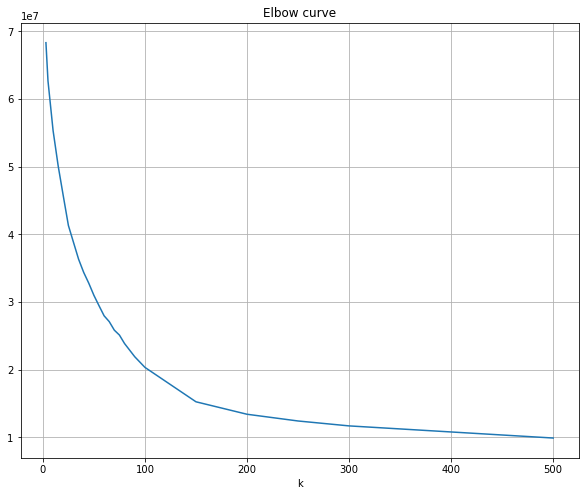

In [62]:
# Plot Inertia Values
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Elbow curve')
ax.set_xlabel('k')
ax.plot(k_values, distortions)
ax.grid(True)

Next we graph how the silhouette score changes with different values of k.

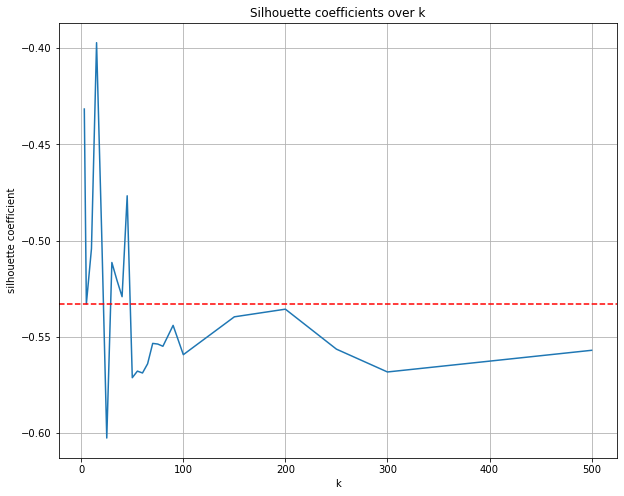

In [65]:
# Plot Silhouette coefficient
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Silhouette coefficients over k')
ax.set_xlabel('k')
ax.set_ylabel('silhouette coefficient')
ax.plot(k_values, silhouette_plot)
ax.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
ax.grid(True)

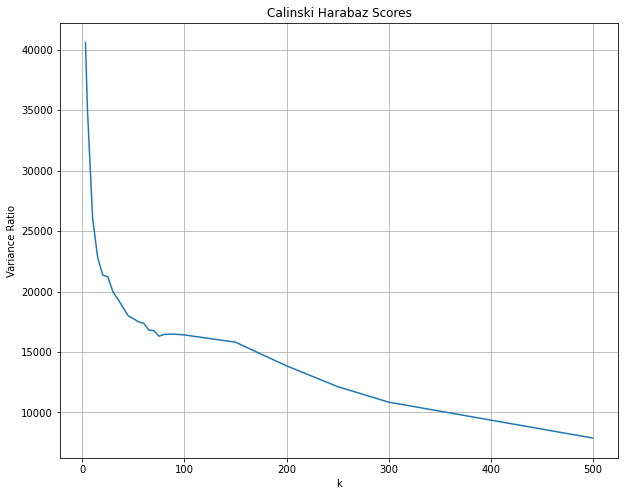

In [66]:
# Plot CH Score Values
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Calinski Harabaz Scores')
ax.set_xlabel('k')
ax.set_ylabel('Variance Ratio')
ax.plot(k_values, ch_score)
ax.grid(True)

A k value of 100 is a good tradeoff between the results of our various scoring metrics.  The CH score is near an inflection point before it begins to trail off.  The silhouette score is close to the average score.  Also, the inertia (which should be minimized) reaches an 'elbow' at k = ~100.  

The average silhouette score is negative, so our clusters are likely not well defined, however the results from our clustering may still add useful features to use in the KNN Regression.

In [24]:
#Create best model
best_cluster = KMeans(n_clusters=100, random_state=70, n_jobs=-1, algorithm='full')

#Fit model.
best_cluster_fit = best_cluster.fit(X_train_reduced)

#Get labels for use in silhouette score calculations
best_cluster_labels = best_cluster_fit.predict(X_train_reduced)

sil_scores = silhouette_samples(X_train_reduced, best_cluster_labels)

/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [30]:
sil_scores.shape

(573773,)

In [31]:
best_cluster_labels.shape

(573773,)

In [32]:
#Save the silhouette scores
dump(sil_scores, 'sil_scores_kmeans.joblib') 

#Save the model
dump(best_cluster_fit, 'kmeans_100_fit.joblib')

#Save the predictions
dump(best_cluster_labels, 'kmeans_100_labels.joblib')

['kmeans_100_labels.joblib']

## Merge New Features with Data

In [8]:
sil_scores = load('sil_scores_kmeans.joblib')
best_cluster_fit = load('kmeans_100_fit.joblib')
best_cluster_labels = load('kmeans_100_labels.joblib')

Change clustering results to Pandas Series objects for concatenation with main data set.

In [9]:
sil_scores = pd.Series(sil_scores, name='sil_score')
sil_scores.shape

(573773,)

In [10]:
best_cluster_labels = pd.Series(best_cluster_labels, name='cluster_label')
best_cluster_labels.shape

(573773,)

In [11]:
X_train_fe = X_train_ohe.reset_index()
X_train_fe.drop('index', axis=1, inplace=True)

In [12]:
to_concat = [X_train_fe, sil_scores, best_cluster_labels]
X_train_fe = pd.concat(to_concat, axis=1)


In [13]:
X_train_fe.shape

(573773, 183)

In [14]:
X_train_fe.head()

,device.isMobile,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,trafficSource.adwordsClickInfo.page,visitNumber,product_price,channelGrouping_(Other),channelGrouping_Affiliates,...,product_category_Gift Cards,product_category_Lifestyle,product_category_Limited Supply,product_category_None,product_category_Office,product_category_Other,product_category_Shop by Brand,product_category_TYCTWD 2018,sil_score,cluster_label
0,False,9,7,2,101,0.0,1,1.99,0,0,...,0,0,0,0,1,0,0,0,0.058531,96
1,False,11,7,31,111,0.0,5,74.99,0,0,...,0,0,0,0,0,0,0,0,0.140763,89
2,False,9,7,-1,115,0.0,2,34.99,0,0,...,0,0,0,0,0,0,0,0,0.110155,89
3,False,4,4,-1,64,0.0,1,16.99,0,0,...,0,0,0,0,0,0,1,0,0.019855,14
4,False,48,28,70,228,0.0,33,18.99,0,0,...,0,0,0,0,0,0,0,0,0.143554,63


In [15]:
X_train_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573773 entries, 0 to 573772
Columns: 183 entries, device.isMobile to cluster_label
dtypes: bool(1), float64(3), int32(1), int64(5), uint8(173)
memory usage: 132.4 MB


The new X_train_fe dataframe now contains columns that communicate the results of the K Means clustering.  This should add additional predictive capability to our model.

# Tuned Random Forest Model - With New Features

In [19]:
#Create pipeline
pipe_forest_fe = Pipeline([('scl', StandardScaler()),
#             ('pca', PCA(n_components=0.85)),
            ('forest', RandomForestRegressor(random_state=70, n_jobs=-1, warm_start=True))])

In [16]:
# Create the grid parameter
grid_forest_fe = [{'forest__n_estimators': [80, 100, 120], 
             'forest__max_depth': [15, 20, 25], 
             'forest__min_samples_split': [20, 25, 30], 
             'forest__min_samples_leaf': [30, 35, 40],
             'forest__criterion': ['mse'],
             'forest__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_forest_fe = RandomizedSearchCV(estimator=pipe_forest_fe, 
                          param_distributions=grid_forest_fe, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          return_train_score=True, #Include training results in cv_results
                          cv=5, #Use 5 folds in CV process
                          n_iter=10, #Try 5 hyperparameter combinations
                          n_jobs=-1, #Use paralell computing
                          verbose=8) #Give updates on progress during fitting

In [18]:
gridsearch_forest_fe.fit(X_train_fe, y_train)

In [26]:
gridsearch_forest_fe = load('gridsearch_forest_fe.joblib') 

In [27]:
gridsearch_forest_fe.best_params_

{'forest__n_estimators': 100,
 'forest__min_samples_split': 25,
 'forest__min_samples_leaf': 40,
 'forest__max_features': None,
 'forest__max_depth': 15,
 'forest__criterion': 'mse'}

In [28]:
gridsearch_forest_fe.best_score_

0.1525381419123042

We've further tuned our model, and the R-Squared is now greater than our previous best models.

In [ ]:
#Save the model
dump(gridsearch_forest_fe, 'gridsearch_forest_fe.joblib') 

In [29]:
gridsearch_forest_fe_df = pd.DataFrame.from_dict(gridsearch_forest_fe.cv_results_)
best_models_fe = gridsearch_forest_fe_df.loc[gridsearch_forest_fe_df['rank_test_r2'] < 6]
best_models_fe[['params', 'rank_test_r2','mean_test_r2', 'mean_train_r2', 'rank_test_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error']]

,params,rank_test_r2,mean_test_r2,mean_train_r2,rank_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
0,"{'forest__n_estimators': 100, 'forest__min_sam...",1,0.152538,0.194483,1,-65.405244,-64.440268
1,"{'forest__n_estimators': 80, 'forest__min_samp...",3,0.152106,0.194341,4,-65.426053,-64.445320
3,"{'forest__n_estimators': 120, 'forest__min_sam...",5,0.149472,0.201947,8,-65.471654,-64.141335
4,"{'forest__n_estimators': 120, 'forest__min_sam...",5,0.149472,0.201947,8,-65.471654,-64.141335
5,"{'forest__n_estimators': 100, 'forest__min_sam...",4,0.149533,0.213348,3,-65.425877,-63.677720
6,"{'forest__n_estimators': 80, 'forest__min_samp...",2,0.152137,0.194600,2,-65.424857,-64.434995


The difference between the training and test results in the above dataframe show that there are still issues with overfitting to the training data.  In future iterations of this project the Forest will be further pruned to reduce the severity of this issue.

For now we will continue on using the model with the best results from this gridsearch.

# Final Model

## Cross Validation

In [48]:
#Create pipeline
pipe_forest_test = Pipeline([('scl', StandardScaler()),
            ('foresttest', RandomForestRegressor(random_state=70, n_jobs=-1, warm_start=True, verbose=8))])

In [49]:
# Create the grid parameter
grid_forest_test = [{'foresttest__n_estimators': [100], 
             'foresttest__max_depth': [15], 
             'foresttest__min_samples_split': [25], 
             'foresttest__min_samples_leaf': [40],
             'foresttest__criterion': ['mse'],
             'foresttest__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_forest_test = GridSearchCV(estimator=pipe_forest_test, 
                          param_grid=grid_forest_test, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          return_train_score=True, #Include training results in cv_results
                          cv=5, #Use 5 folds in CV process
                          n_jobs=-1, #Use paralell computing
                          verbose=8) #Give updates on progress during fitting

In [50]:
gridsearch_forest_test.fit(X_train_fe, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 22.4min remaining: 33.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 22.5min remaining: 15.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100building tree 3 of 100
building tree 4 of 100building tree 5 of 100
building tree 6 of 100
building tree 7 of 100


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.2s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.0min


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed:  5.8min remaining:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('foresttest',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=70,
                                                              verbose=8,
                                                              warm_start=True))]),
             n_jobs=-1,
             param_grid=[{'foresttest__criterion': ['mse'],
                          'foresttest__max_depth': [15],
                          'foresttest__max_features': [None],
                          'foresttest__min_samples_leaf': [40],
                          'foresttest__min_samples_split': [25],
                          'foresttest__n_estimators': [100]}],
             refit='r2', return_train_score=True,
             scoring=['r2', 'neg_root_mean_squared_error'], verbose=8)

The R-Squared score has dropped here.  Future iterations on this project will analyze why this occurred and further improve the R-Squared score.

In [51]:
gridsearch_forest_test.best_score_

0.08546536292432785

## Model Fitting

Now we actually fit the model on our training data using the best parameters from the grid search.  We do not include PCA in the pipeline so that we can extract usable feature importances from the model.

In [16]:
#Create pipeline
pipe_best_forest = Pipeline([('scl', StandardScaler()),
            ('forest', RandomForestRegressor(n_estimators = 100,
                                             min_samples_split=25,
                                             min_samples_leaf=40,
                                             max_features=None,
                                             max_depth=15,
                                             criterion='mse',
                                             random_state=70,
                                             n_jobs=-1,
                                             warm_start=True))])

In [78]:
pipe_best_forest.fit(X_train_fe, y_train)

/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Pipeline(steps=[('scl', StandardScaler()),
                ('forest',
                 RandomForestRegressor(max_depth=15, max_features=None,
                                       min_samples_leaf=40,
                                       min_samples_split=25, n_jobs=-1,
                                       random_state=70, warm_start=True))])

In [31]:
#Save the model
dump(pipe_best_forest, 'best_forest_mvp.joblib') 

['best_forest_mvp.joblib']

In [31]:
# pipe_best_forest = load('best_forest_mvp.joblib')

## Examine Most Important Features

Using the results of the final random forest model, we can see the most important features in predicting revenue.  Further analysis is available in the Results_Analysis.ipynb notebook, or in the Presentation.pdf

In [32]:
importances = pd.Series(pipe_best_forest['forest'].feature_importances_, name='importance')

In [33]:
feature = pd.Series(list(X_train_fe.columns), name='feature')

In [34]:
feature_importances = pd.concat([feature, importances], axis=1)
top_features = feature_importances.sort_values(by='importance', ascending=False).head(20)
dump(top_features, '../Data/top_features.joblib')

['../Data/top_features.joblib']

In [35]:
top_features

,feature,importance
6,visitNumber,0.344964
2,totals.pageviews,0.225344
182,cluster_label,0.074352
181,sil_score,0.059625
1,totals.hits,0.053662
10,channelGrouping_Direct,0.040644
3,totals.sessionQualityDim,0.038069
4,totals.timeOnSite,0.029292
7,product_price,0.029018
45,geoNetwork.networkDomain_comcastbusiness.net,0.016827


## Model Evaluation vs Test Data

First we must apply our manipulation and feature engineering to the test data in order to get it into the proper formatting.

In [62]:
X_test_ohe = pd.get_dummies(X_test)

pipe_reduce = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.755, random_state=70))])

X_test_reduced = pipe_reduce.fit_transform(X_test_ohe)

In [63]:
test_cluster_labels = best_cluster_fit.predict(X_test_reduced)

In [64]:
test_sil_scores = silhouette_samples(X_test_reduced, test_cluster_labels)

In [65]:
test_sil_scores = pd.Series(test_sil_scores, name='sil_score')
test_sil_scores.shape

(143444,)

In [66]:
test_cluster_labels = pd.Series(test_cluster_labels, name='cluster_label')
test_cluster_labels.shape

(143444,)

In [67]:
X_test_fe = X_test_ohe.reset_index()
X_test_fe.drop('index', axis=1, inplace=True)

In [68]:
to_concat = [X_test_fe, test_sil_scores, test_cluster_labels]
X_test_fe = pd.concat(to_concat, axis=1)

One column is missing from the test data.

In [73]:
missing_cols = []
for column in X_train_fe.columns:
    if column not in X_test_fe.columns:
        missing_cols.append(column)
missing_cols

['trafficSource.adwordsClickInfo.adNetworkType_Search partners']

Add the missing column to the test data with all values of 0.

In [74]:
X_test_fe['trafficSource.adwordsClickInfo.adNetworkType_Search partners'] = 0

Check that there are no columns in the test data that aren't in the training data.

In [77]:
missing_cols2 = []
for column in X_test_fe.columns:
    if column not in X_train_fe.columns:
        missing_cols2.append(column)
missing_cols2

[]

Now the test data is in the proper format to score our model.

In [79]:
pipe_best_forest.score(X_test_fe, y_test)

0.008493949032797543

This indicates severe issues with overfitting in our best model.  This shows that the model is not ready for deployment, as it does not handle unseen/new data well at all.

The model will be improved further in future iterations of this project.

# **Further Visualizations**

This section of the notebook contains analysis of the most important features of our data in terms of predicting revenue from a visit to the online store.

First we determine the most important features.  Next we explore the relationship between these features and the amount of revenue generated from a visit to the store.

In [3]:
df = pd.read_csv('../Data/data4.csv', dtype={'fullVisitorId': 'str'})
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 24 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   device.browser                                717217 non-null  object 
 2   device.deviceCategory                         717217 non-null  object 
 3   device.isMobile                               717217 non-null  bool   
 4   device.operatingSystem                        717217 non-null  object 
 5   geoNetwork.networkDomain                      717217 non-null  object 
 6   revenue_usd                                   717217 non-null  float64
 7   time_of_day                                   717217 non-null  object 
 8   totals.hits                                   717217 non-null  int64  
 9   totals.pageviews                              71

After importing the data set, separate into multiple DataFrames: One for visits that end with a purchase, and one for visits where no purchase is made.  This will be useful in our analysis of features.

In [4]:
purchase = df.loc[df['revenue_usd'] != 0]
no_purchase = df.loc[df['revenue_usd'] == 0]

The top 20 features from the final Random Forest model are shown below.  We will analyze the data in the most important categories/features below.

In [5]:
top_features = load('../Data/top_features.joblib')
top_features

,feature,importance
6,visitNumber,0.344964
2,totals.pageviews,0.225344
182,cluster_label,0.074352
181,sil_score,0.059625
1,totals.hits,0.053662
10,channelGrouping_Direct,0.040644
3,totals.sessionQualityDim,0.038069
4,totals.timeOnSite,0.029292
7,product_price,0.029018
45,geoNetwork.networkDomain_comcastbusiness.net,0.016827


# Top 10 Features

Here we visualize the top 10 features, sorted by importance in our random forest model.  We exclude the results from our clustering algorithm in this chart so that only direct customer attributes are visualized.

In [13]:
tf = top_features.head(13).reset_index().drop('index', axis=1)
tf.drop([2, 3, 4], inplace=True)
tf = tf.reset_index().drop('index', axis=1)
tf

,feature,importance
0,visitNumber,0.344964
1,totals.pageviews,0.225344
2,channelGrouping_Direct,0.040644
3,totals.sessionQualityDim,0.038069
4,totals.timeOnSite,0.029292
5,product_price,0.029018
6,geoNetwork.networkDomain_comcastbusiness.net,0.016827
7,product_category_Apparel,0.015837
8,device.operatingSystem_Chrome OS,0.011745
9,product_category_Office,0.011432


Now graph the importances of each feature.  This shows that the number of visits to the online store is by far the most important feature in predicting revenue.  This makes sense; why would a customer return to the store many times if they have no interest in buying a product there?

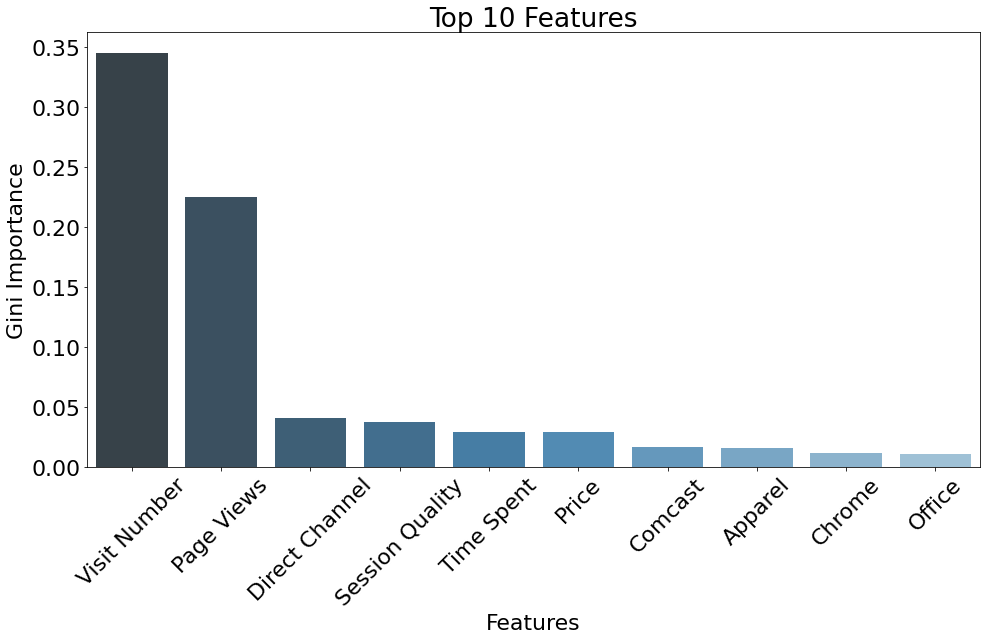

In [21]:
#Format Feature Names for Graph
tf_labels = ['Visit Number', 'Page Views', 'Direct Channel', 'Session Quality', 'Time Spent', 'Price', 'Comcast', 'Apparel', 'Chrome', 'Office']

#Graph
plt.subplots(figsize=(16, 8))

plt.xticks(rotation=45)

plt.title('Top 10 Features')
ax = sns.barplot(x=tf_labels, y='importance', data=tf, palette='Blues_d')

plt.ylabel('Gini Importance')
plt.xlabel('Features')
plt.rcParams.update({'font.size': 22})

Now we will visualize the relationships between these top features and revenue:

# Number of Visits to the Store

What is the relationship between revenue and number of visits to the store a customer has made?  Here we only consider the visits that result in a purchase.

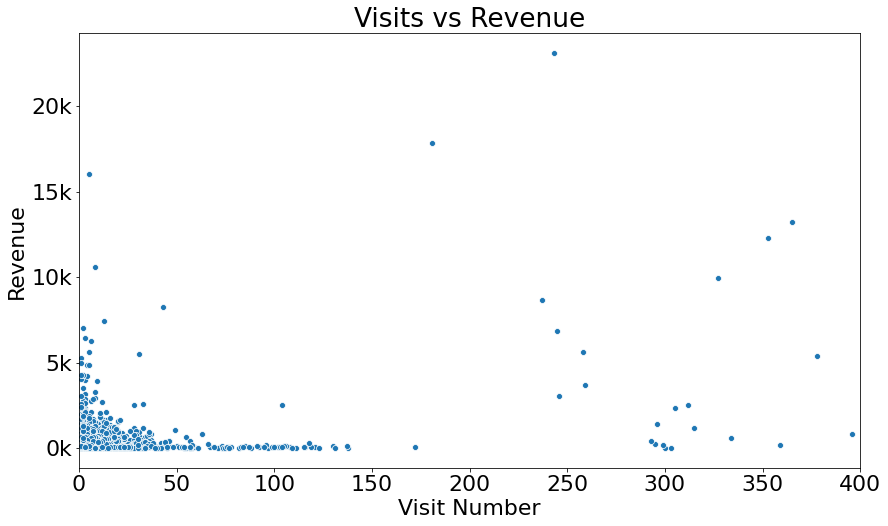

In [32]:
# Revenue vs Visits to Store
plt.subplots(figsize=(14, 8))
ax = sns.scatterplot(x='visitNumber', y='revenue_usd', data=purchase)
plt.xlim(0, 400)
plt.ylabel('Revenue')
plt.xlabel('Visit Number')
plt.title('Visits vs Revenue')
plt.rcParams.update({'font.size': 22})
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: str(round(y / 1000)) + 'k'))

We can see that most purchases are made within the first 30 or so visits to the Google store.  Large purchases are likely to be made in the first ~20 visits to the store.  As visits increase past 50, purchase amounts grow smaller.  This could be attributed to customers that repeatedly visit the store for small goods that wear out quickly like earbuds, chargers, and gift cards.

Also note that there are a few customers that visited the store hundreds of times in our data collection period.  These customers tended to spend more.  These outlier observations could be negatively impacting the predictive power of our model.  In further iterations of this project we will consider removing these visits from the dataset.

Now we consider the median visit number for visits that end in purchases vs those that do not.  We see that the average number of visits for those that make a purchase (2 visits) is almost double that of those that do not make a purchase.  We can infer that many customers only go to the store once, decide they do not want a Google product, then never return to the store.

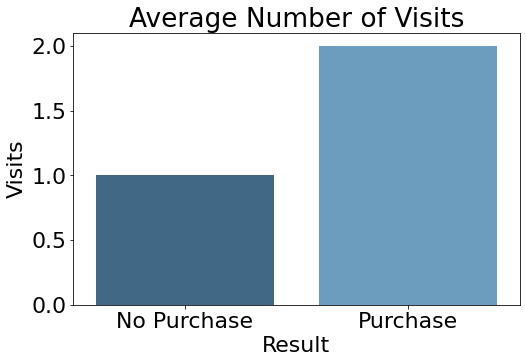

In [39]:
plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=['No Purchase', 'Purchase'], 
                 y=[no_purchase['visitNumber'].median(), 
                    purchase['visitNumber'].median()], 
                 palette='Blues_d')
# plt.xlabel('Visit Type')
plt.ylabel('Visits')
plt.xlabel('Result')

plt.title('Average Number of Visits')
plt.rcParams.update({'font.size': 22})

# Number of Pages Viewed in Visit to the Store

Now examine the number of pages viewed, and its relationship with revenue.  This appears to have a negative relationship with revenue.  As page views pass 100, revenue tends to drop.

We will consider excluding outlier page views from future iterations of modeling.

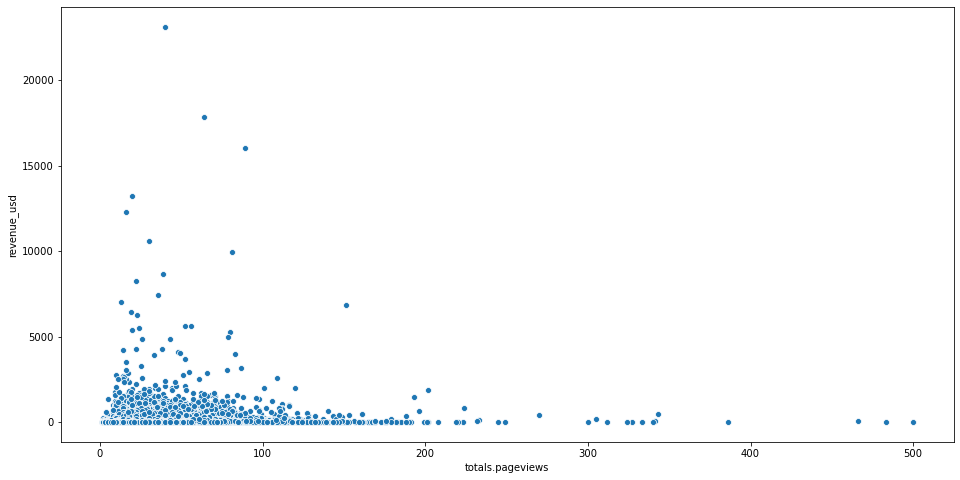

In [7]:
# Revenue vs Pages Viewed on Site
plt.subplots(figsize=(16, 8))
ax = sns.scatterplot(x='totals.pageviews', y='revenue_usd', data=df)

# Chanel Grouping

How do people get to the Google store?  And how much do they spend once they get there?

Here we find that 'Display' ads (banner ads and similar) lead to high average purchase sizes.  Additionally, customers that navigate directly to the google store purchase large amounts on average.

On the other hand, social media and affiliate marketing tends to lead to smaller purchases in general.

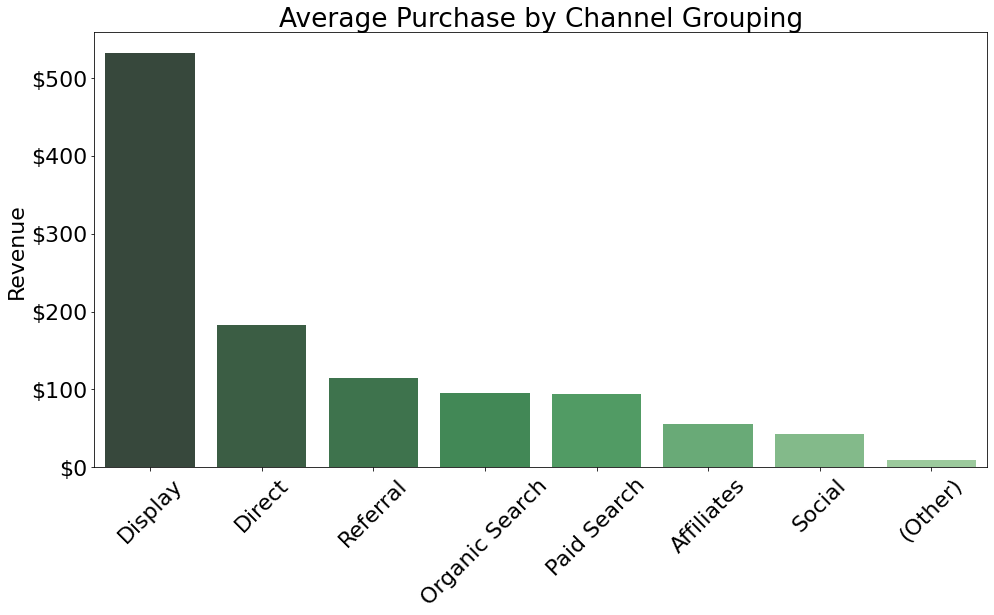

In [46]:
channel_purch = purchase.groupby('channelGrouping').mean().sort_values(by='revenue_usd', ascending=False)

#Graph
plt.subplots(figsize=(16, 8))
ax = sns.barplot(x=channel_purch.index, y='revenue_usd', data=channel_purch, palette='Greens_d')


plt.xticks(rotation=45)

plt.title('Average Purchase by Channel Grouping')

plt.ylabel('Revenue')
plt.xlabel('')
plt.rcParams.update({'font.size': 22})
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: '$' + str(round(y))))

Average purchase size only accounts for half of the story, however.  Here we examine which channels lead to the highest percent of purchases of any size.

Here we see that referrals are much more likely to lead to a purchase than any other kind of channel.  Referrals also have the 3rd highest average purchase size, so this is a valuable channel.

Even though display ads have high average purchase sizes, we see here that they are less likely to convince a customer to actually make that purchase.

Social media and affiliate marketing attract many customers who do not end up making a purchase.  Even when they do make a purchase, it is smaller on average than customers acquired from other channels.

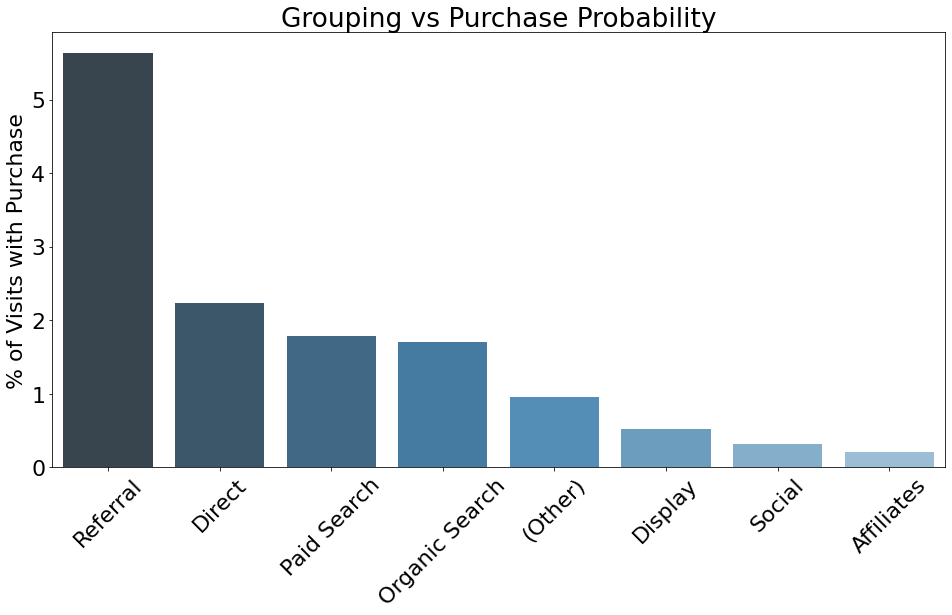

In [43]:
channel_count_p = purchase.groupby('channelGrouping').count()
channel_count_p['purchase_count'] = channel_count_p['visitNumber']
channel_count_p = channel_count_p[['purchase_count']]

channel_count_np = no_purchase.groupby('channelGrouping').count()
channel_count_np['non_purchase_count'] = channel_count_np['visitNumber']
channel_count_np = channel_count_np[['non_purchase_count']]


channel_count = pd.concat([channel_count_p, channel_count_np], axis=1)
channel_count['percent_purchase'] = channel_count['purchase_count'] / (channel_count['purchase_count'] + channel_count['non_purchase_count']) * 100
channel_count.sort_values(by='percent_purchase', ascending=False, inplace=True)


#Graph
plt.subplots(figsize=(16, 8))
ax = sns.barplot(x=channel_count.index, y='percent_purchase', data=channel_count, palette='Blues_d')


plt.xticks(rotation=45)

plt.title('Grouping vs Purchase Probability')

plt.ylabel('% of Visits with Purchase')
plt.xlabel('')
plt.rcParams.update({'font.size': 22})

# Time Spent in the Online Store

Time spent on the site has a similar relationship to revenue as number of pages visited.  This is to be expected, as more time on the site is likely correlated to how many pages are viewed in a given visit.

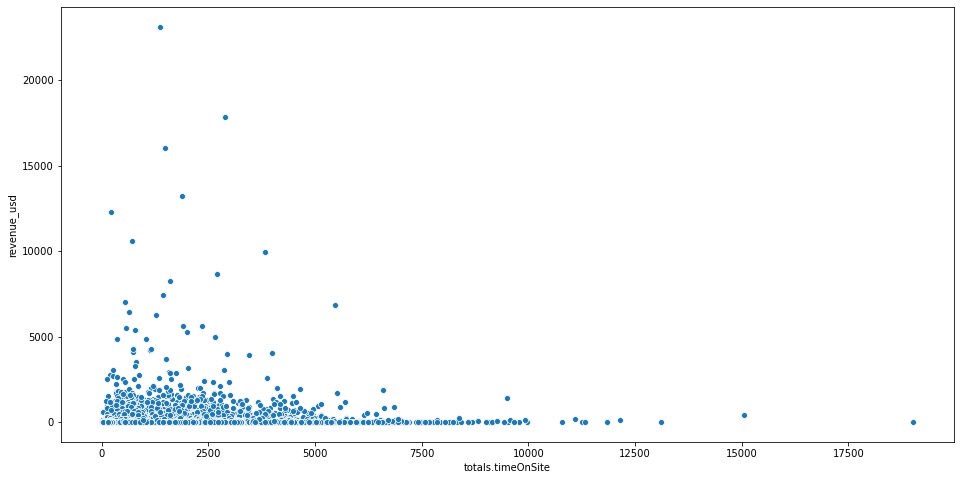

In [11]:
# Revenue vs Time Spent on Site
plt.subplots(figsize=(16, 8))
ax = sns.scatterplot(x='totals.timeOnSite', y='revenue_usd', data=df)

# Price of the Last Product Viewed

Most products viewed are relatively cheap (<$100). Some products have much higher price points.  These outliers may be removed from future iterations of this project.

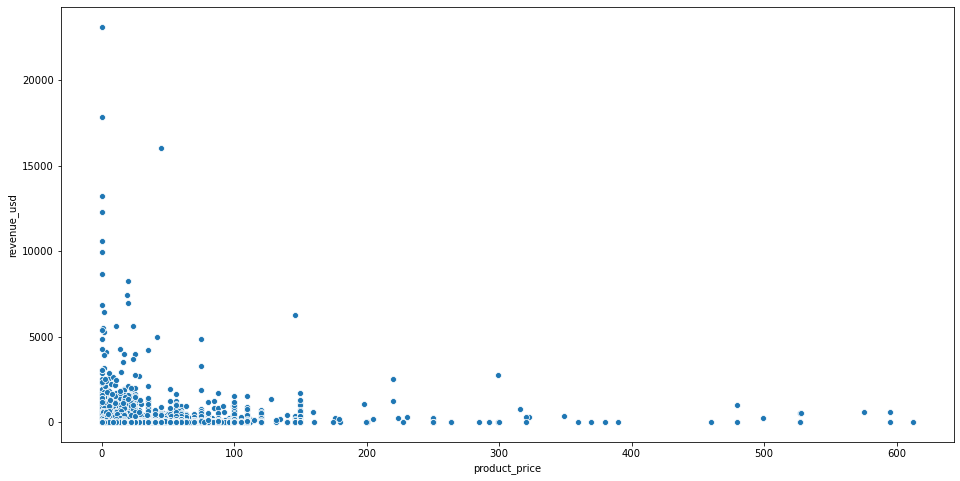

In [12]:
# Revenue vs Price of Last Product
plt.subplots(figsize=(16, 8))
ax = sns.scatterplot(x='product_price', y='revenue_usd', data=df)

In [13]:
tf = top_features.head(13).reset_index().drop('index', axis=1)
tf.drop([2, 3, 4], inplace=True)
tf = tf.reset_index().drop('index', axis=1)
tf

,feature,importance
0,visitNumber,0.344964
1,totals.pageviews,0.225344
2,channelGrouping_Direct,0.040644
3,totals.sessionQualityDim,0.038069
4,totals.timeOnSite,0.029292
5,product_price,0.029018
6,geoNetwork.networkDomain_comcastbusiness.net,0.016827
7,product_category_Apparel,0.015837
8,device.operatingSystem_Chrome OS,0.011745
9,product_category_Office,0.011432


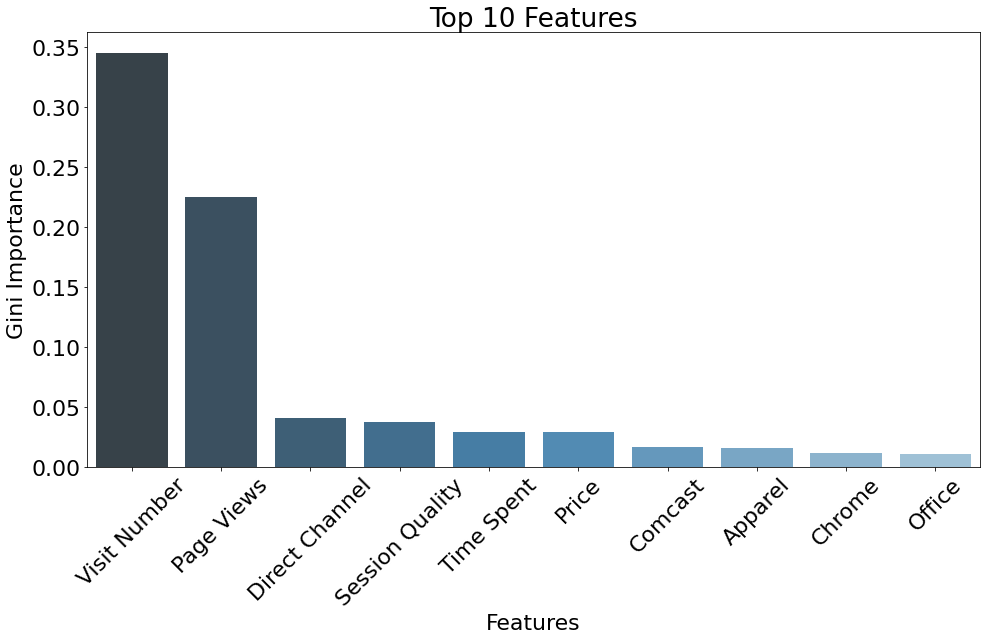

In [21]:
#Format Feature Names for Graph
tf_labels = ['Visit Number', 'Page Views', 'Direct Channel', 'Session Quality', 'Time Spent', 'Price', 'Comcast', 'Apparel', 'Chrome', 'Office']

#Graph
plt.subplots(figsize=(16, 8))

plt.xticks(rotation=45)

plt.title('Top 10 Features')
ax = sns.barplot(x=tf_labels, y='importance', data=tf, palette='Blues_d')

plt.ylabel('Gini Importance')
plt.xlabel('Features')
plt.rcParams.update({'font.size': 22})